# This notebook does peak hydrologic discharge calculation
##### Author: Omid Emamjomehzadeh (https://www.omidemam.com/)
##### Supervisor: Dr. Omar Wani (https://engineering.nyu.edu/faculty/omar-wani)
##### Hydrologic Systems Group @NYU (https://www.omarwani.com/)

In [2]:
# load libraries
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from scipy.interpolate import interp1d
import seaborn as sns
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.patches import Ellipse
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from matplotlib.colors import ListedColormap
from matplotlib import rcParams
from datetime import datetime
import textwrap
import re
import os
import glob
from tqdm import tqdm
import datetime

In [2]:
import warnings
# Suppress the specific RuntimeWarning
warnings.filterwarnings("ignore")
# Suppress all UserWarnings, including PerformanceWarnings
warnings.simplefilter('ignore', category=UserWarning)
# Set pandas display option to show all columns
pd.set_option('display.max_columns', None)

In [3]:
# Clip the five points of usgs station like culverts to make approporiate input for the model
path= r"D:\culvert repo\data\USGS\dis_sta_RP - streamstats.csv"
dis=pd.read_csv(path)
dis = dis.drop(index=2)
dis

,agency_cd,site_no,station_nm,site_tp_cd,dec_lat_va,dec_long_va,coord_acy_cd,dec_coord_datum_cd,alt_va,alt_acy_va,...,2_year_dis,Str_stat_2_year,NRCS_2_year,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28
0,USGS,1362342,HOLLOW TREE BROOK AT LANESVILLE NY,ST,42.141750,-74.264861,1,NAD83,1476.46,0.1,...,115.00,170.00,104.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USGS,1422389,COULTER BROOK NEAR BOVINA CENTER NY,ST,42.238528,-74.735972,1,NAD83,NaN,NaN,...,19.50,76.00,19.940000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USGS,4253294,"BUCK CREEK, SOUTH TRIBUTARY, NEAR INLET NY",ST,43.741889,-74.710917,1,NAD83,1940.00,10.0,...,9.00,8.98,9.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USGS,4253295,"BUCK CREEK, NORTH TRIBUTARY, NEAR INLET NY",ST,43.743694,-74.713222,1,NAD83,1980.00,10.0,...,3.59,6.93,1.152368,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,USGS,4253296,BUCK CREEK NEAR INLET NY,ST,43.744028,-74.721667,1,NAD83,1850.00,10.0,...,74.65,44.60,47.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
dis.columns

Index(['agency_cd', 'site_no', 'station_nm', 'site_tp_cd', 'dec_lat_va',
       'dec_long_va', 'coord_acy_cd', 'dec_coord_datum_cd', 'alt_va',
       'alt_acy_va', 'alt_datum_cd', 'huc_cd', 'geometry', 'drain_Area',
       'data_Length', 'start_time', 'end_time', 'time_interval', 'len_record',
       '2_year_dis', 'Str_stat_2_year', 'NRCS_2_year', 'Unnamed: 22',
       'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26',
       'Unnamed: 27', 'Unnamed: 28'],
      dtype='object')

In [5]:
# Define paths
paths = [
    r"C:\hydrological analysis\data\waterhsed_delineation_dir_val\020200060903\020200060903_watersheds_info_val.shp",
    r"C:\hydrological analysis\data\waterhsed_delineation_dir_val\020401010105\020401010105_watersheds_info_val.shp",
    r"C:\hydrological analysis\data\waterhsed_delineation_dir_val\041403010503\041403010503_watersheds_info_val.shp"
]

# Read and concatenate
gdfs = [gpd.read_file(path) for path in paths]
culvert = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs=gdfs[0].crs)


In [6]:
culvert.Area_80=culvert.Area_80/2_589_988.110336


In [7]:
#print(culvert.BIN+''+culvert.Area_80/2_589_988.110336)
print(culvert[['BIN', 'Area_40']])

print(dis[['site_no', 'drain_Area']])


       BIN       Area_40
0  1362342  5.111436e+06
1  1422389  2.045580e+06
2  4253294  4.894385e+05
3  4253296  2.628082e+02
4  4253295  2.791352e+05
   site_no  drain_Area
0  1362342        1.95
1  1422389        0.76
3  4253294        0.21
4  4253295        0.19
5  4253296        1.16


In [3]:
# Load culverts watershed
file_path=r"D:\culvert repo\Results\waterhsed_delineation_dir\combined_watersheds_info.shp"
culvert = gpd.read_file(file_path)
# Show the data frame
print(culvert.shape)
# Show the data frame columns
print(culvert.columns)
# number of rows with nan
print(f'number of rows with nan value: {int(culvert.isna().any(axis=1).sum())}')

(7474, 36)
Index(['BIN', 'Ini_lon', 'Ini_lat', 'lonsnap_10', 'latsnap_10', 'Area_10',
       'Peri_10', 'LFP_len_10', 'LFP_S_10', 'Bas_S_10', 'cul_S10',
       'lonsnap_20', 'latsnap_20', 'Area_20', 'Peri_20', 'LFP_len_20',
       'LFP_S_20', 'Bas_S_20', 'cul_S20', 'lonsnap_40', 'latsnap_40',
       'Area_40', 'Peri_40', 'LFP_len_40', 'LFP_S_40', 'Bas_S_40', 'cul_S40',
       'lonsnap_80', 'latsnap_80', 'Area_80', 'Peri_80', 'LFP_len_80',
       'LFP_S_80', 'Bas_S_80', 'cul_S80', 'geometry'],
      dtype='object')
number of rows with nan value: 0


# Clean the dataset

In [8]:
# Remove duplicate rows based on BIN column, keep the first instance
culvert_cleaned = culvert.drop_duplicates(subset=['BIN'], keep='first')
# Reset the index
culvert_cleaned.reset_index(drop=True, inplace=True)
# Print the shape to verify
print(culvert_cleaned.shape)

(5, 36)


In [9]:
# Sanity checks (Area and length cant be negative)
conditions = {
    'Area_10': culvert_cleaned['Area_10'] <= 0,
    'Area_20': culvert_cleaned['Area_20'] <= 0,
    'Area_40': culvert_cleaned['Area_40'] <= 0,
    'Area_80': culvert_cleaned['Area_80'] <= 0,
    'LFP_len_10': culvert_cleaned['LFP_len_10'] <= 0,
    'LFP_len_20': culvert_cleaned['LFP_len_20'] <= 0,
    'LFP_len_40': culvert_cleaned['LFP_len_40'] <= 0,
    'LFP_len_80': culvert_cleaned['LFP_len_80'] <= 0,

}
# Print the number of rows to be removed and their percentages for each column
for col, condition in conditions.items():
    count = condition.sum()
    percent = (count / len(culvert_cleaned)) * 100
    print(f'Rows with {col} <= 0: {count}, percent of rows: {percent:.2f} %')
# Combine the conditions to get the total number of rows to be removed
combined_conditions = np.logical_or.reduce(list(conditions.values()))
# Replace values based on combined conditions with NaN
for col in culvert_cleaned.columns:
    if col in conditions:
        culvert_cleaned[col] = np.where(combined_conditions, np.nan, culvert_cleaned[col])
# Create a new dataframe with rows that don't have any NaN values in the specified columns
Culvert_clea_remov = culvert_cleaned.dropna(subset=conditions.keys())
culvert=Culvert_clea_remov
# Print the total number of changed records
num_removed_combined = combined_conditions.sum()
print(f'Total number of removed records: {num_removed_combined}, percent of rows: {(num_removed_combined / len(culvert_cleaned)) * 100:.1f} %')
print(f'Number of rows with nan value in culvert dataframe: {int(culvert.isna().any(axis=1).sum())}')
print(f'Culvert dataframe shape is {culvert.shape}')

Rows with Area_10 <= 0: 0, percent of rows: 0.00 %
Rows with Area_20 <= 0: 0, percent of rows: 0.00 %
Rows with Area_40 <= 0: 0, percent of rows: 0.00 %
Rows with Area_80 <= 0: 0, percent of rows: 0.00 %
Rows with LFP_len_10 <= 0: 0, percent of rows: 0.00 %
Rows with LFP_len_20 <= 0: 0, percent of rows: 0.00 %
Rows with LFP_len_40 <= 0: 0, percent of rows: 0.00 %
Rows with LFP_len_80 <= 0: 0, percent of rows: 0.00 %
Total number of removed records: 0, percent of rows: 0.0 %
Number of rows with nan value in culvert dataframe: 0
Culvert dataframe shape is (5, 36)


#### Check the drainge area

In [52]:
culvert['Area']=culvert['Area_80']*(2.58999/1.00000073)*10**6

#### Time of concentration

In [11]:
culvert['LFP_len']=culvert['LFP_len_80']
culvert['Bas_S']=culvert['Bas_S_80']

In [13]:
%%time
# caclulate time of the concentration
# t_c=0.000325*(l**0.77)*(s_w**-0.385)
# t_c (hr), l (m), s_w (%)
culvert['t_c'] = (0.019 * (culvert['LFP_len'] ** 0.77) * ((culvert['Bas_S']/100) ** -0.385))/60
# show the results
culvert.head()

CPU times: total: 0 ns
Wall time: 0 ns


,BIN,Ini_lon,Ini_lat,lonsnap_10,latsnap_10,Area_10,Peri_10,LFP_len_10,LFP_S_10,Bas_S_10,...,Peri_80,LFP_len_80,LFP_S_80,Bas_S_80,cul_S80,geometry,Area,LFP_len,Bas_S,t_c
0,1362342,-74.264861,42.141751,-74.264913,42.141791,40.891890,43.941952,14.052504,13.330,11.376221,...,12980.851953,4511.211636,14.798,48.571901,5.722001,"MULTIPOLYGON (((1768866.004 2332971.299, 17688...",1.975613,4511.211636,48.571901,0.272364
1,1422389,-74.735972,42.238528,-74.736029,42.238561,10677.924956,1187.500316,491.141057,10.202,14.123786,...,8868.395815,2723.923582,15.016,30.351971,4.728943,"POLYGON ((1728819.883 2331838.242, 1728828.849...",0.790326,2723.923582,30.351971,0.221340
2,4253294,-74.710917,43.741889,-74.710966,43.741931,1002.454108,157.642968,63.896916,22.478,35.133728,...,10518.178250,2096.568682,5.455,19.332815,5.303036,"POLYGON ((1693534.064 2496036.225, 1693535.062...",0.614402,2096.568682,19.332815,0.215249
3,4253296,-74.721667,43.744028,-74.721727,43.744042,98.553085,61.859899,24.258767,11.764,15.319755,...,14281.654664,3446.292683,4.855,23.407542,2.898376,"POLYGON ((1692621.132 2496074.139, 1692622.13 ...",1.151386,3446.292683,23.407542,0.293198
4,4253295,-74.713222,43.743694,-74.713281,43.743723,169.232570,67.846340,23.674304,15.084,15.225368,...,5046.570441,1915.410429,4.690,28.828404,4.397638,"POLYGON ((1693898.24 2497354.24, 1693900.235 2...",0.108015,1915.410429,28.828404,0.172152


In [15]:
culvert['t_c'].describe()

count    5.000000
mean     0.234861
std      0.048243
min      0.172152
25%      0.215249
50%      0.221340
75%      0.272364
max      0.293198
Name: t_c, dtype: float64

# CN calculation

In [94]:
# Gather all paths for different watershed files
# Define the root directory to search in
root_dir = r'C:\hydrological analysis\data\waterhsed_delineation_dir_val'
# Define the pattern to search for shapefiles
pattern = os.path.join(root_dir, '**', '*watershed_poly_*m.shp')
# Use glob to find all matching shapefiles
shapefile_paths = glob.glob(pattern, recursive=True)
# Print the number of shapefiles found
print(f"Found {len(shapefile_paths)} shapefiles.")

Found 20 shapefiles.


In [17]:
culvert['Closest_Area']=80

In [18]:
def select_closest_area(row):
    error = str(row['Closest_Area'])
    return error

In [19]:
CN_path = r"D:\culvert repo\Results\CN\CN_Map_2021_filled.tif"
# Define the root directory to search in
# Use tqdm to show progress
for idx, row in tqdm(culvert.iterrows(), total=culvert.shape[0], desc='number of processed rows'):
    error=select_closest_area(row)
    ###############################################################################################################################################
    # find the path to the file 
    # Construct the specific filename pattern
    specific_pattern = f"{culvert['BIN'].iloc[idx]}watershed_poly_{error}m.shp"
    # Find the path related to the specific pattern
    matching_path = None
    for path in shapefile_paths:
        if specific_pattern in os.path.basename(path):
            matching_path = path
            break
    if matching_path is None:
        print("No matching shapefile found.")
        culvert.loc[idx, f"CN"] = np.nan
        continue
    ###############################################################################################################################################
    watershed_polygone = matching_path
    watershed = gpd.read_file(watershed_polygone)
    # Convert the watershed boundary to GeoJSON-like format
    watershed_geom = [feature["geometry"] for feature in watershed.__geo_interface__["features"]]
    ###############################################################################################################################################
    # Open the precipitation TIFF file and clip it using the watershed boundary
    with rasterio.open(CN_path) as src:
        out_image, out_transform = mask(src, watershed_geom, crop=True, all_touched=True)
        # Set NoData value
        out_image[out_image == src.nodata] = 0
        # Calculate the mean of the clipped raster excluding NoData values
        if np.count_nonzero(out_image) == 0:  # Check if the data is empty (no non-zero values)
            mean_value = np.nan
        else:
            mean_value = np.nanmean(np.where(out_image == 0, np.nan, out_image))
    # Update the DataFrame with the mean value for the given error
    culvert.loc[idx, f"CN"] = mean_value

number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.71it/s]


In [20]:
CN_path = r"D:\culvert repo\Results\CN\CN_Map_dry_2021_filled.tif"

for idx, row in tqdm(culvert.iterrows(), total=culvert.shape[0], desc='number of processed rows'):
    error=select_closest_area(row)
    ###############################################################################################################################################
    # find the path to the file 
    # Construct the specific filename pattern
    specific_pattern = f"{culvert['BIN'].iloc[idx]}watershed_poly_{error}m.shp"
    # Find the path related to the specific pattern
    matching_path = None
    for path in shapefile_paths:
        if specific_pattern in os.path.basename(path):
            matching_path = path
            break
    if matching_path is None:
        print("No matching shapefile found.")
        culvert.loc[idx, f"CN_dry"] = np.nan
        continue
    ###############################################################################################################################################
    watershed_polygone = matching_path
    watershed = gpd.read_file(watershed_polygone)
    # Convert the watershed boundary to GeoJSON-like format
    watershed_geom = [feature["geometry"] for feature in watershed.__geo_interface__["features"]]
    ###############################################################################################################################################
    # Open the precipitation TIFF file and clip it using the watershed boundary
    with rasterio.open(CN_path) as src:
        out_image, out_transform = mask(src, watershed_geom, crop=True, all_touched=True)
        # Set NoData value
        out_image[out_image == src.nodata] = 0
        # Calculate the mean of the clipped raster excluding NoData values
        if np.count_nonzero(out_image) == 0:  # Check if the data is empty (no non-zero values)
            mean_value = np.nan
        else:
            mean_value = np.nanmean(np.where(out_image == 0, np.nan, out_image))
    # Update the DataFrame with the mean value for the given error
    culvert.loc[idx, f"CN_dry"] = mean_value

number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.40it/s]


In [21]:
CN_path = r"D:\culvert repo\Results\CN\CN_Map_wet_2021_filled.tif"
for idx, row in tqdm(culvert.iterrows(), total=culvert.shape[0], desc='number of processed rows'):
    error=select_closest_area(row)
    ###############################################################################################################################################
    # find the path to the file 
    # Construct the specific filename pattern
    specific_pattern = f"{culvert['BIN'].iloc[idx]}watershed_poly_{error}m.shp"
    # Find the path related to the specific pattern
    matching_path = None
    for path in shapefile_paths:
        if specific_pattern in os.path.basename(path):
            matching_path = path
            break
    if matching_path is None:
        print("No matching shapefile found.")
        culvert.loc[idx, f"CN_wet"] = np.nan
        continue
    ###############################################################################################################################################
    watershed_polygone = matching_path
    watershed = gpd.read_file(watershed_polygone)
    # Convert the watershed boundary to GeoJSON-like format
    watershed_geom = [feature["geometry"] for feature in watershed.__geo_interface__["features"]]
    ###############################################################################################################################################
    # Open the precipitation TIFF file and clip it using the watershed boundary
    with rasterio.open(CN_path) as src:
        out_image, out_transform = mask(src, watershed_geom, crop=True, all_touched=True)
        # Set NoData value
        out_image[out_image == src.nodata] = 0
        # Calculate the mean of the clipped raster excluding NoData values
        if np.count_nonzero(out_image) == 0:  # Check if the data is empty (no non-zero values)
            mean_value = np.nan
        else:
            mean_value = np.nanmean(np.where(out_image == 0, np.nan, out_image))
    # Update the DataFrame with the mean value for the given error
    culvert.loc[idx, f"CN_wet"] = mean_value

number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.80it/s]


In [23]:
# Caclulate time of the concentration based on CN value
culvert[f't_c_CN'] =  (((culvert[f'LFP_len']*3.28) ** 0.8)*((1000/culvert[f'CN'])-10+1)**0.7 )/(1140*culvert[f'Bas_S'])
culvert[f't_c_CN_dry'] =  (((culvert[f'LFP_len']*3.28) ** 0.8)*((1000/culvert[f'CN_dry'])-10+1)**0.7 )/(1140*culvert[f'Bas_S'])
culvert[f't_c_CN_wet'] =  (((culvert[f'LFP_len']*3.28) ** 0.8)*((1000/culvert[f'CN_wet'])-10+1)**0.7 )/(1140*culvert[f'Bas_S'])
# show the results
culvert.head()

,BIN,Ini_lon,Ini_lat,lonsnap_10,latsnap_10,Area_10,Peri_10,LFP_len_10,LFP_S_10,Bas_S_10,...,LFP_len,Bas_S,t_c,Closest_Area,CN,CN_dry,CN_wet,t_c_CN,t_c_CN_dry,t_c_CN_wet
0,1362342,-74.264861,42.141751,-74.264913,42.141791,40.891890,43.941952,14.052504,13.330,11.376221,...,4511.211636,48.571901,0.272364,80,64.123451,44.581253,80.270165,0.146653,0.241278,0.093329
1,1422389,-74.735972,42.238528,-74.736029,42.238561,10677.924956,1187.500316,491.141057,10.202,14.123786,...,2723.923582,30.351971,0.221340,80,66.069508,47.089781,81.314439,0.149026,0.241608,0.096501
2,4253294,-74.710917,43.741889,-74.710966,43.741931,1002.454108,157.642968,63.896916,22.478,35.133728,...,2096.568682,19.332815,0.215249,80,66.673586,46.977167,82.320706,0.186781,0.308544,0.118931
3,4253296,-74.721667,43.744028,-74.721727,43.744042,98.553085,61.859899,24.258767,11.764,15.319755,...,3446.292683,23.407542,0.293198,80,64.126134,44.507086,80.377834,0.245322,0.404427,0.155604
4,4253295,-74.713222,43.743694,-74.713281,43.743723,169.232570,67.846340,23.674304,15.084,15.225368,...,1915.410429,28.828404,0.172152,80,58.177378,38.874036,75.760925,0.144890,0.238849,0.090785


#### GEE CN 

In [95]:
# normal
CN_path = r"D:\culvert repo\data\initial layers\GEE\GCN250_Average_NY_reprojected.tif"
# Define the root directory to search in
# Progress bar
for idx, row in tqdm(culvert.iterrows(), total=culvert.shape[0], desc='number of processed rows'):
    error=select_closest_area(row)
    ###############################################################################################################################################
    # Find the path to the file 
    # Construct the specific filename pattern
    specific_pattern = f"{culvert['BIN'].iloc[idx]}watershed_poly_{error}m.shp"
    # Find the path related to the specific pattern
    matching_path = None
    for path in shapefile_paths:
        if specific_pattern in os.path.basename(path):
            matching_path = path
            break
    if matching_path is None:
        print("No matching shapefile found.")
        culvert.loc[idx, f"CN"] = np.nan
        continue
    ###############################################################################################################################################
    watershed_polygone = matching_path
    watershed = gpd.read_file(watershed_polygone)
    # Convert the watershed boundary to GeoJSON-like format
    watershed_geom = [feature["geometry"] for feature in watershed.__geo_interface__["features"]]
    ###############################################################################################################################################
    # Open the precipitation TIFF file and clip it using the watershed boundary
    with rasterio.open(CN_path) as src:
        out_image, out_transform = mask(src, watershed_geom, crop=True, all_touched=True)
        # Set NoData value
        out_image[out_image == src.nodata] = 0
        # Calculate the mean of the clipped raster, excluding NoData values
        if np.count_nonzero(out_image) == 0:  # Check if the data is empty (no non-zero values)
            mean_value = np.nan
        else:
            mean_value = np.nanmean(np.where(out_image == 0, np.nan, out_image))
    # Update the DataFrame with the mean value for the given error
    culvert.loc[idx, f"GEE_CN"] = mean_value

number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.71it/s]


In [96]:
# wet
CN_path = r"D:\culvert repo\data\initial layers\GEE\GCN250_Wet_NY_reprojected.tif"
# Define the root directory to search in
# Progress bar
for idx, row in tqdm(culvert.iterrows(), total=culvert.shape[0], desc='number of processed rows'):
    error=select_closest_area(row)
    ###############################################################################################################################################
    # Find the path to the file 
    # Construct the specific filename pattern
    specific_pattern = f"{culvert['BIN'].iloc[idx]}watershed_poly_{error}m.shp"
    # Find the path related to the specific pattern
    matching_path = None
    for path in shapefile_paths:
        if specific_pattern in os.path.basename(path):
            matching_path = path
            break
    if matching_path is None:
        print("No matching shapefile found.")
        culvert.loc[idx, f"CN"] = np.nan
        continue
    ###############################################################################################################################################
    watershed_polygone = matching_path
    watershed = gpd.read_file(watershed_polygone)
    # Convert the watershed boundary to GeoJSON-like format
    watershed_geom = [feature["geometry"] for feature in watershed.__geo_interface__["features"]]
    ###############################################################################################################################################
    # Open the precipitation TIFF file and clip it using the watershed boundary
    with rasterio.open(CN_path) as src:
        out_image, out_transform = mask(src, watershed_geom, crop=True, all_touched=True)
        # Set NoData value
        out_image[out_image == src.nodata] = 0
        # Calculate the mean of the clipped raster, excluding NoData values
        if np.count_nonzero(out_image) == 0:  # Check if the data is empty (no non-zero values)
            mean_value = np.nan
        else:
            mean_value = np.nanmean(np.where(out_image == 0, np.nan, out_image))
    # Update the DataFrame with the mean value for the given error
    culvert.loc[idx, f"GEE_CN_wet"] = mean_value

number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 29.24it/s]


In [97]:
# dry
CN_path = r"D:\culvert repo\data\initial layers\GEE\GCN250_Dry_NY_reprojected.tif"
# Define the root directory to search in
# Progress bar
for idx, row in tqdm(culvert.iterrows(), total=culvert.shape[0], desc='number of processed rows'):
    error=select_closest_area(row)
    ###############################################################################################################################################
    # Find the path to the file 
    # Construct the specific filename pattern
    specific_pattern = f"{culvert['BIN'].iloc[idx]}watershed_poly_{error}m.shp"
    # Find the path related to the specific pattern
    matching_path = None
    for path in shapefile_paths:
        if specific_pattern in os.path.basename(path):
            matching_path = path
            break
    if matching_path is None:
        print("No matching shapefile found.")
        culvert.loc[idx, f"CN"] = np.nan
        continue
    ###############################################################################################################################################
    watershed_polygone = matching_path
    watershed = gpd.read_file(watershed_polygone)
    # Convert the watershed boundary to GeoJSON-like format
    watershed_geom = [feature["geometry"] for feature in watershed.__geo_interface__["features"]]
    ###############################################################################################################################################
    # Open the precipitation TIFF file and clip it using the watershed boundary
    with rasterio.open(CN_path) as src:
        out_image, out_transform = mask(src, watershed_geom, crop=True, all_touched=True)
        # Set NoData value
        out_image[out_image == src.nodata] = 0
        # Calculate the mean of the clipped raster, excluding NoData values
        if np.count_nonzero(out_image) == 0:  # Check if the data is empty (no non-zero values)
            mean_value = np.nan
        else:
            mean_value = np.nanmean(np.where(out_image == 0, np.nan, out_image))
    # Update the DataFrame with the mean value for the given error
    culvert.loc[idx, f"GEE_CN_dry"] = mean_value

number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.79it/s]


In [98]:
# Calculate the time of the concentration based on different ASM states using NRCS method which is based on CN
culvert[f't_c_CN'] =  (((culvert[f'LFP_len']*3.28) ** 0.8)*((1000/culvert[f'CN'])-10+1)**0.7 )/(1140*culvert[f'Bas_S'])
culvert[f't_c_CN_dry'] =  (((culvert[f'LFP_len']*3.28) ** 0.8)*((1000/culvert[f'CN_dry'])-10+1)**0.7 )/(1140*culvert[f'Bas_S'])
culvert[f't_c_CN_wet'] =  (((culvert[f'LFP_len']*3.28) ** 0.8)*((1000/culvert[f'CN_wet'])-10+1)**0.7 )/(1140*culvert[f'Bas_S'])
culvert[f't_c_GEE_CN'] =  (((culvert[f'LFP_len']*3.28) ** 0.8)*((1000/culvert[f'GEE_CN'])-10+1)**0.7 )/(1140*culvert[f'Bas_S'])
culvert[f't_c_GEE_CN_dry'] =  (((culvert[f'LFP_len']*3.28) ** 0.8)*((1000/culvert[f'GEE_CN_dry'])-10+1)**0.7 )/(1140*culvert[f'Bas_S'])
culvert[f't_c_GEE_CN_wet'] =  (((culvert[f'LFP_len']*3.28) ** 0.8)*((1000/culvert[f'GEE_CN_wet'])-10+1)**0.7 )/(1140*culvert[f'Bas_S'])

In [25]:
for scenario in ['A1B']:
        for year in [2030,2040,2050,2060,2070,2080,2090,2100]:
            for ASM in ['Dry','Normal','Wet']:
                CN_path = rf"D:\culvert repo\Results\CN\{scenario}\{ASM}\CN_Map_{year}_filled.tif"
                # Define the root directory to search in
                root_dir = r"D:\culvert repo\Results\waterhsed_delineation_dir"
                print(scenario,year)
                # Use tqdm to show progress
                for idx, row in tqdm(culvert.iterrows(), total=culvert.shape[0], desc='number of processed rows'):
                    error=select_closest_area(row)
                    ###############################################################################################################################################
                    # find the path to the file 
                    # Construct the specific filename pattern
                    specific_pattern = f"{culvert['BIN'].iloc[idx]}watershed_poly_{error}m.shp"
                    # Find the path related to the specific pattern
                    matching_path = None
                    for path in shapefile_paths:
                        if specific_pattern in os.path.basename(path):
                            matching_path = path
                            break
                    if matching_path is None:
                        print("No matching shapefile found.")
                        culvert.loc[idx, f"CN_{year}_{scenario}_{ASM}"] = np.nan
                        continue
                    ###############################################################################################################################################
                    watershed_polygone = matching_path
                    watershed = gpd.read_file(watershed_polygone)
                    # Convert the watershed boundary to GeoJSON-like format
                    watershed_geom = [feature["geometry"] for feature in watershed.__geo_interface__["features"]]
                    ###############################################################################################################################################
                    # Open the precipitation TIFF file and clip it using the watershed boundary
                    with rasterio.open(CN_path) as src:
                        out_image, out_transform = mask(src, watershed_geom, crop=True, all_touched=True)
                        # Set NoData value
                        out_image[out_image == src.nodata] = 0
                        # Calculate the mean of the clipped raster excluding NoData values
                        if np.count_nonzero(out_image) == 0:  # Check if the data is empty (no non-zero values)
                            mean_value = np.nan
                        else:
                            mean_value = np.nanmean(np.where(out_image == 0, np.nan, out_image))
                    # Assign the calculated mean value to the dataframe
                    culvert.loc[idx, f"CN_{year}_{scenario}_{ASM}"] = mean_value

A1B 2030


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.41it/s]


A1B 2030


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 27.46it/s]


A1B 2030


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 34.05it/s]


A1B 2040


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 32.38it/s]


A1B 2040


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.92it/s]


A1B 2040


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 27.54it/s]


A1B 2050


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.63it/s]


A1B 2050


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 33.21it/s]


A1B 2050


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 33.66it/s]


A1B 2060


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 33.63it/s]


A1B 2060


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 29.56it/s]


A1B 2060


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 34.50it/s]


A1B 2070


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.37it/s]


A1B 2070


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 30.91it/s]


A1B 2070


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.26it/s]


A1B 2080


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.56it/s]


A1B 2080


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 36.27it/s]


A1B 2080


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.52it/s]


A1B 2090


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.60it/s]


A1B 2090


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.07it/s]


A1B 2090


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 30.27it/s]


A1B 2100


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 27.12it/s]


A1B 2100


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 30.50it/s]


A1B 2100


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 30.92it/s]


In [26]:
for scenario in ['A2']:
        for year in [2030,2040,2050,2060,2070,2080,2090,2100]:
            for ASM in ['Dry','Normal','Wet']:
                CN_path = rf"D:\culvert repo\Results\CN\{scenario}\{ASM}\CN_Map_{year}_filled.tif"
                # Define the root directory to search in
                root_dir = r"D:\culvert repo\Results\waterhsed_delineation_dir"
                print(scenario,year)
                # Use tqdm to show progress
                for idx, row in tqdm(culvert.iterrows(), total=culvert.shape[0], desc='number of processed rows'):
                    ###############################################################################################################################################
                    # find the path to the file 
                    # Construct the specific filename pattern
                    error=select_closest_area(row)
                    specific_pattern = f"{culvert['BIN'].iloc[idx]}watershed_poly_{error}m.shp"
                    # Find the path related to the specific pattern
                    matching_path = None
                    for path in shapefile_paths:
                        if specific_pattern in os.path.basename(path):
                            matching_path = path
                            break
                    if matching_path is None:
                        print("No matching shapefile found.")
                        culvert.loc[idx, f"CN_{year}_{scenario}_{ASM}"] = np.nan
                        continue
                    ###############################################################################################################################################
                    watershed_polygone = matching_path
                    watershed = gpd.read_file(watershed_polygone)
                    # Convert the watershed boundary to GeoJSON-like format
                    watershed_geom = [feature["geometry"] for feature in watershed.__geo_interface__["features"]]
                    ###############################################################################################################################################
                    # Open the precipitation TIFF file and clip it using the watershed boundary
                    with rasterio.open(CN_path) as src:
                        out_image, out_transform = mask(src, watershed_geom, crop=True, all_touched=True)
                        # Set NoData value
                        out_image[out_image == src.nodata] = 0
                        # Calculate the mean of the clipped raster excluding NoData values
                        if np.count_nonzero(out_image) == 0:  # Check if the data is empty (no non-zero values)
                            mean_value = np.nan
                        else:
                            mean_value = np.nanmean(np.where(out_image == 0, np.nan, out_image))
                    # Assign the calculated mean value to the dataframe
                    culvert.loc[idx, f"CN_{year}_{scenario}_{ASM}"] = mean_value

A2 2030


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.41it/s]


A2 2030


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.69it/s]


A2 2030


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 40.17it/s]


A2 2040


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 33.10it/s]


A2 2040


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 32.91it/s]


A2 2040


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 36.88it/s]


A2 2050


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 33.42it/s]


A2 2050


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 30.05it/s]


A2 2050


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 27.75it/s]


A2 2060


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.52it/s]


A2 2060


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 33.87it/s]


A2 2060


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 37.06it/s]


A2 2070


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 34.59it/s]


A2 2070


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 27.92it/s]


A2 2070


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 33.05it/s]


A2 2080


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.07it/s]


A2 2080


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.04it/s]


A2 2080


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 29.81it/s]


A2 2090


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.28it/s]


A2 2090


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 32.02it/s]


A2 2090


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 36.58it/s]


A2 2100


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 30.91it/s]


A2 2100


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 38.63it/s]


A2 2100


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 34.97it/s]


In [27]:
for scenario in ['B1']:
        for year in [2030,2040,2050,2060,2070,2080,2090,2100]:
            for ASM in ['Dry','Normal','Wet']:
                CN_path = rf"D:\culvert repo\Results\CN\{scenario}\{ASM}\CN_Map_{year}_filled.tif"
                # Define the root directory to search in
                root_dir = r"D:\culvert repo\Results\waterhsed_delineation_dir"
                print(scenario,year)
                # Use tqdm to show progress
                for idx, row in tqdm(culvert.iterrows(), total=culvert.shape[0], desc='number of processed rows'):
                    ###############################################################################################################################################
                    # find the path to the file 
                    # Construct the specific filename pattern
                    error=select_closest_area(row)
                    specific_pattern = f"{culvert['BIN'].iloc[idx]}watershed_poly_{error}m.shp"
                    # Find the path related to the specific pattern
                    matching_path = None
                    for path in shapefile_paths:
                        if specific_pattern in os.path.basename(path):
                            matching_path = path
                            break
                    if matching_path is None:
                        print("No matching shapefile found.")
                        culvert.loc[idx, f"CN_{year}_{scenario}_{ASM}"] = np.nan
                        continue
                    ###############################################################################################################################################
                    watershed_polygone = matching_path
                    watershed = gpd.read_file(watershed_polygone)
                    # Convert the watershed boundary to GeoJSON-like format
                    watershed_geom = [feature["geometry"] for feature in watershed.__geo_interface__["features"]]
                    ###############################################################################################################################################
                    # Open the precipitation TIFF file and clip it using the watershed boundary
                    with rasterio.open(CN_path) as src:
                        out_image, out_transform = mask(src, watershed_geom, crop=True, all_touched=True)
                        # Set NoData value
                        out_image[out_image == src.nodata] = 0
                        # Calculate the mean of the clipped raster excluding NoData values
                        if np.count_nonzero(out_image) == 0:  # Check if the data is empty (no non-zero values)
                            mean_value = np.nan
                        else:
                            mean_value = np.nanmean(np.where(out_image == 0, np.nan, out_image))
                    # Assign the calculated mean value to the dataframe
                    culvert.loc[idx, f"CN_{year}_{scenario}_{ASM}"] = mean_value

B1 2030


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.73it/s]


B1 2030


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 32.36it/s]


B1 2030


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.24it/s]


B1 2040


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.69it/s]


B1 2040


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 37.58it/s]


B1 2040


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 32.69it/s]


B1 2050


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 29.17it/s]


B1 2050


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 36.27it/s]


B1 2050


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.28it/s]


B1 2060


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 30.58it/s]


B1 2060


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 44.99it/s]


B1 2060


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 40.09it/s]


B1 2070


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 33.54it/s]


B1 2070


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 27.05it/s]


B1 2070


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.46it/s]


B1 2080


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 30.08it/s]


B1 2080


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 36.22it/s]


B1 2080


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 36.08it/s]


B1 2090


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.46it/s]


B1 2090


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 27.13it/s]


B1 2090


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 32.89it/s]


B1 2100


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 32.84it/s]


B1 2100


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 35.83it/s]


B1 2100


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.64it/s]


In [28]:
for scenario in ['B2']:
        for year in [2030,2040,2050,2060,2070,2080,2090,2100]:
            for ASM in ['Dry','Normal','Wet']:
                CN_path = rf"D:\culvert repo\Results\CN\{scenario}\{ASM}\CN_Map_{year}_filled.tif"
                # Define the root directory to search in
                root_dir = r"D:\culvert repo\Results\waterhsed_delineation_dir"
                print(scenario,year)
                # Use tqdm to show progress
                for idx, row in tqdm(culvert.iterrows(), total=culvert.shape[0], desc='number of processed rows'):
                    ###############################################################################################################################################
                    # find the path to the file 
                    # Construct the specific filename pattern
                    error=select_closest_area(row)
                    specific_pattern = f"{culvert['BIN'].iloc[idx]}watershed_poly_{error}m.shp"
                    # Find the path related to the specific pattern
                    matching_path = None
                    for path in shapefile_paths:
                        if specific_pattern in os.path.basename(path):
                            matching_path = path
                            break
                    if matching_path is None:
                        print("No matching shapefile found.")
                        culvert.loc[idx, f"CN_{year}_{scenario}_{ASM}"] = np.nan
                        continue
                    ###############################################################################################################################################
                    watershed_polygone = matching_path
                    watershed = gpd.read_file(watershed_polygone)
                    # Convert the watershed boundary to GeoJSON-like format
                    watershed_geom = [feature["geometry"] for feature in watershed.__geo_interface__["features"]]
                    ###############################################################################################################################################
                    # Open the precipitation TIFF file and clip it using the watershed boundary
                    with rasterio.open(CN_path) as src:
                        out_image, out_transform = mask(src, watershed_geom, crop=True, all_touched=True)
                        # Set NoData value
                        out_image[out_image == src.nodata] = 0
                        # Calculate the mean of the clipped raster excluding NoData values
                        if np.count_nonzero(out_image) == 0:  # Check if the data is empty (no non-zero values)
                            mean_value = np.nan
                        else:
                            mean_value = np.nanmean(np.where(out_image == 0, np.nan, out_image))
                    # Assign the calculated mean value to the dataframe
                    culvert.loc[idx, f"CN_{year}_{scenario}_{ASM}"] = mean_value

B2 2030


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.55it/s]


B2 2030


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.24it/s]


B2 2030


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.25it/s]


B2 2040


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.43it/s]


B2 2040


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.40it/s]


B2 2040


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.78it/s]


B2 2050


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.29it/s]


B2 2050


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.54it/s]


B2 2050


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 35.92it/s]


B2 2060


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.78it/s]


B2 2060


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 33.40it/s]


B2 2060


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 39.40it/s]


B2 2070


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.26it/s]


B2 2070


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 32.44it/s]


B2 2070


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 38.28it/s]


B2 2080


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 30.98it/s]


B2 2080


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 27.89it/s]


B2 2080


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 34.16it/s]


B2 2090


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.62it/s]


B2 2090


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.21it/s]


B2 2090


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 36.76it/s]


B2 2100


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.79it/s]


B2 2100


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.19it/s]


B2 2100


number of processed rows: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 35.30it/s]


In [41]:
# Define the output file path for Excel
#excel_output_file = r'D:\culvert repo\Results\Peak hydrologic discharge\culvert_future_A1B_A2_B1_B2_CN_tc.xlsx'
# Save the DataFrame to an Excel file
#culvert.to_excel(excel_output_file, index=False)
#print(f"culvert_CN_tc saved to {excel_output_file}")

culvert_CN_tc saved to D:\culvert repo\Results\Peak hydrologic discharge\culvert_future_A1B_A2_B1_B2_CN_tc.xlsx


In [29]:
# Caclulate time of the concentration based on projected CN value
for scenario in ['A1B', 'A2', 'B1', 'B2']:
    for year in [2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100]:
        for ASM in ['Dry', 'Normal', 'Wet']:
            culvert[f't_CN_{year}_{scenario}_{ASM}'] =  (((culvert[f'LFP_len']*3.28) ** 0.8)*\
            ((1000/culvert[f'CN_{year}_{scenario}_{ASM}'])-10+1)**0.7 )/(1140*culvert[f'Bas_S'])
# Show the results
culvert.head()

,BIN,Ini_lon,Ini_lat,lonsnap_10,latsnap_10,Area_10,Peri_10,LFP_len_10,LFP_S_10,Bas_S_10,...,t_CN_2070_B2_Wet,t_CN_2080_B2_Dry,t_CN_2080_B2_Normal,t_CN_2080_B2_Wet,t_CN_2090_B2_Dry,t_CN_2090_B2_Normal,t_CN_2090_B2_Wet,t_CN_2100_B2_Dry,t_CN_2100_B2_Normal,t_CN_2100_B2_Wet
0,1362342,-74.264861,42.141751,-74.264913,42.141791,40.891890,43.941952,14.052504,13.330,11.376221,...,0.086911,0.217917,0.134198,0.086911,0.217917,0.134198,0.086911,0.217917,0.134198,0.086911
1,1422389,-74.735972,42.238528,-74.736029,42.238561,10677.924956,1187.500316,491.141057,10.202,14.123786,...,0.101839,0.259843,0.159946,0.102025,0.259843,0.159946,0.102025,0.261997,0.160458,0.102707
2,4253294,-74.710917,43.741889,-74.710966,43.741931,1002.454108,157.642968,63.896916,22.478,35.133728,...,0.118275,0.301040,0.184429,0.118275,0.301040,0.184429,0.118275,0.301040,0.184429,0.118275
3,4253296,-74.721667,43.744028,-74.721727,43.744042,98.553085,61.859899,24.258767,11.764,15.319755,...,0.152026,0.386874,0.237425,0.152026,0.386874,0.237425,0.152026,0.386874,0.237425,0.152026
4,4253295,-74.713222,43.743694,-74.713281,43.743723,169.232570,67.846340,23.674304,15.084,15.225368,...,0.079340,0.195456,0.122211,0.079340,0.195456,0.122211,0.079340,0.195456,0.122211,0.079340


In [30]:
plt.rcParams.update({'font.size': 16, 'axes.labelsize': 18, 'axes.titlesize': 20,
                     'xtick.labelsize': 16, 'ytick.labelsize': 16, 'legend.fontsize': 16})

# compute $S$ and $I_a$

In [32]:
%%time
# Calculate average storage for drainage area for normal, dry, and wet asm
# S=(2540/CN)-25.4
# S storage (cm)
culvert[f'S']=(2540/culvert[f'CN'])-25.4
# Calculation of initial abstraction (Ia=0.2*S) (cm)
culvert[f'Ia']=0.2*culvert[f'S']
# For dry and wet conditions of current land use
for asm in['dry','wet']:
    culvert[f'S_{asm}']=(2540/culvert[f'CN_{asm}'])-25.4
    # Calculation of initial abstraction (Ia=0.2*S) Ia(cm)
    culvert[f'Ia_{asm}']=0.2*culvert[f'S_{asm}']
# for future land use projections
for scenario in ['A1B','A2','B1','B2']:
    for year in [2030,2040,2050,2060,2070,2080,2090,2100]:
        for ASM in ['Dry', 'Normal', 'Wet']:
            culvert[f'S_{year}_{scenario}_{ASM}']=(2540/culvert[f'CN_{year}_{scenario}_{ASM}'])-25.4
            # Calculation of initial abstraction (Ia=0.2*S) (cm)
            culvert[f'Ia_{year}_{scenario}_{ASM}']=0.2*culvert[f'S_{year}_{scenario}_{ASM}']

CPU times: total: 46.9 ms
Wall time: 55.2 ms


In [46]:
# Save the DataFrame to an Excel file
output_file = r'D:\hydrological analysis\data\Peak hydrologic discharge\culvert_CN_tc_S_Ia.xlsx'
#culvert.to_excel(output_file, index=False)
print(f"culvert_CN_tc_S_Ia saved to {output_file}")

culvert_CN_tc_S_Ia saved to D:\hydrological analysis\data\Peak hydrologic discharge\culvert_CN_tc_S_Ia.xlsx


# compute historical rian with diffrent return periods 

In [33]:
# Extract percipitation data
return_periods = ['2', '5', '10', '25', '50', '100', '200', '500', '1000']
durations = ['05m', '10m', '15m', '30m', '60m', '02h', '03h', '06h', '12h', '24h']
bounds = ['a', 'al', 'au']
bounds = ['a','al','au']# modify later

# Create an overall progress bar
total_iterations = len(return_periods) * len(durations) * len(bounds) * culvert.shape[0]
with tqdm(total=total_iterations, desc="Processing All Combinations") as pbar:
    # Iterate over return periods, durations, and bounds
    for return_period in return_periods:
        for duration in durations:
            for bound in bounds:
                print (f'extract rainfall values for return period of {return_period} (years), duration of {duration} (minutes),\
                and uncertainty bound of {bound}')
                folder = f'ne{return_period}yr{duration}{bound}_ams'
                file = f'ne{return_period}yr{duration}{bound}_ams.asc'
                asc_file = rf"D:\culvert repo\data\NOAA IDF\{folder}\{file}"
                # Open the ASCII raster file
                with rasterio.open(asc_file) as src:
                    # Iterate over culverts
                    for idx, row in culvert.iterrows():
                        error = select_closest_area(row)
                        # Find the path to the shapefile
                        specific_pattern = f"{culvert['BIN'].iloc[idx]}watershed_poly_{error}m.shp"
                        matching_path = next((path for path in shapefile_paths if specific_pattern in os.path.basename(path)), None)
                        if matching_path is None:
                            culvert.loc[idx, f"rain_{return_period}_{duration}_{bound}"] = np.nan
                        else:
                            # Read the watershed shapefile
                            watershed = gpd.read_file(matching_path)
                            if watershed.crs != src.crs:
                                watershed = watershed.to_crs(src.crs)
                            watershed_geom = [feature["geometry"] for feature in watershed.__geo_interface__["features"]]
                            # Clip raster using the watershed boundary
                            out_image, out_transform = mask(src, watershed_geom, crop=True, all_touched=True)
                            out_image[out_image == src.nodata] = 0  # Set NoData values to zero
                            # Compute the mean rainfall depth
                            mean_value = np.nan if np.count_nonzero(out_image) == 0 else np.nanmean(np.where(out_image == 0, np.nan, out_image))
                            # Store the result in the DataFrame
                            culvert.loc[idx, f"rain_{return_period}_{duration}_{bound}"] = (mean_value / 1000) * 2.54  # Convert to meters
                        # Update progress bar
                        pbar.update(1)

Processing All Combinations:   0%|                                                            | 0/1350 [00:00<?, ?it/s]

extract rainfall values for return period of 2 (years), duration of 05m (minutes),                and uncertainty bound of a


Processing All Combinations:   0%|▏                                                   | 5/1350 [00:00<03:13,  6.96it/s]

extract rainfall values for return period of 2 (years), duration of 05m (minutes),                and uncertainty bound of al


Processing All Combinations:   1%|▎                                                   | 8/1350 [00:01<02:45,  8.13it/s]

extract rainfall values for return period of 2 (years), duration of 05m (minutes),                and uncertainty bound of au


Processing All Combinations:   1%|▍                                                  | 11/1350 [00:01<02:35,  8.59it/s]

extract rainfall values for return period of 2 (years), duration of 10m (minutes),                and uncertainty bound of a


Processing All Combinations:   1%|▌                                                  | 16/1350 [00:01<02:03, 10.77it/s]

extract rainfall values for return period of 2 (years), duration of 10m (minutes),                and uncertainty bound of al


Processing All Combinations:   2%|▉                                                  | 26/1350 [00:02<01:37, 13.56it/s]

extract rainfall values for return period of 2 (years), duration of 10m (minutes),                and uncertainty bound of au


Processing All Combinations:   2%|█▏                                                 | 31/1350 [00:02<01:30, 14.59it/s]

extract rainfall values for return period of 2 (years), duration of 15m (minutes),                and uncertainty bound of a


Processing All Combinations:   3%|█▎                                                 | 35/1350 [00:02<01:15, 17.39it/s]

extract rainfall values for return period of 2 (years), duration of 15m (minutes),                and uncertainty bound of al


Processing All Combinations:   3%|█▍                                                 | 38/1350 [00:03<01:36, 13.59it/s]

extract rainfall values for return period of 2 (years), duration of 15m (minutes),                and uncertainty bound of au


Processing All Combinations:   3%|█▋                                                 | 45/1350 [00:03<01:22, 15.75it/s]

extract rainfall values for return period of 2 (years), duration of 30m (minutes),                and uncertainty bound of a


Processing All Combinations:   4%|█▊                                                 | 48/1350 [00:04<01:34, 13.75it/s]

extract rainfall values for return period of 2 (years), duration of 30m (minutes),                and uncertainty bound of al


Processing All Combinations:   4%|██                                                 | 55/1350 [00:04<01:18, 16.45it/s]

extract rainfall values for return period of 2 (years), duration of 30m (minutes),                and uncertainty bound of au


Processing All Combinations:   4%|██▏                                                | 58/1350 [00:04<01:28, 14.55it/s]

extract rainfall values for return period of 2 (years), duration of 60m (minutes),                and uncertainty bound of a


Processing All Combinations:   5%|██▍                                                | 65/1350 [00:05<01:17, 16.49it/s]

extract rainfall values for return period of 2 (years), duration of 60m (minutes),                and uncertainty bound of al


Processing All Combinations:   5%|██▌                                                | 68/1350 [00:05<01:31, 14.07it/s]

extract rainfall values for return period of 2 (years), duration of 60m (minutes),                and uncertainty bound of au


Processing All Combinations:   5%|██▊                                                | 74/1350 [00:05<01:25, 14.97it/s]

extract rainfall values for return period of 2 (years), duration of 02h (minutes),                and uncertainty bound of a


Processing All Combinations:   6%|███                                                | 80/1350 [00:06<01:19, 16.01it/s]

extract rainfall values for return period of 2 (years), duration of 02h (minutes),                and uncertainty bound of al


Processing All Combinations:   6%|███▏                                               | 83/1350 [00:06<01:33, 13.52it/s]

extract rainfall values for return period of 2 (years), duration of 02h (minutes),                and uncertainty bound of au


Processing All Combinations:   7%|███▍                                               | 90/1350 [00:06<01:21, 15.52it/s]

extract rainfall values for return period of 2 (years), duration of 03h (minutes),                and uncertainty bound of a


Processing All Combinations:   7%|███▌                                               | 93/1350 [00:07<01:36, 13.03it/s]

extract rainfall values for return period of 2 (years), duration of 03h (minutes),                and uncertainty bound of al


Processing All Combinations:   7%|███▋                                              | 100/1350 [00:07<01:18, 15.86it/s]

extract rainfall values for return period of 2 (years), duration of 03h (minutes),                and uncertainty bound of au


Processing All Combinations:   8%|███▊                                              | 103/1350 [00:07<01:29, 13.90it/s]

extract rainfall values for return period of 2 (years), duration of 06h (minutes),                and uncertainty bound of a


Processing All Combinations:   8%|████                                              | 110/1350 [00:08<01:17, 16.05it/s]

extract rainfall values for return period of 2 (years), duration of 06h (minutes),                and uncertainty bound of al


Processing All Combinations:   8%|████▏                                             | 113/1350 [00:08<01:33, 13.21it/s]

extract rainfall values for return period of 2 (years), duration of 06h (minutes),                and uncertainty bound of au


Processing All Combinations:   9%|████▍                                             | 120/1350 [00:09<01:19, 15.51it/s]

extract rainfall values for return period of 2 (years), duration of 12h (minutes),                and uncertainty bound of a


Processing All Combinations:   9%|████▌                                             | 123/1350 [00:09<01:33, 13.18it/s]

extract rainfall values for return period of 2 (years), duration of 12h (minutes),                and uncertainty bound of al


Processing All Combinations:  10%|████▊                                             | 130/1350 [00:09<01:17, 15.77it/s]

extract rainfall values for return period of 2 (years), duration of 12h (minutes),                and uncertainty bound of au


Processing All Combinations:  10%|████▉                                             | 133/1350 [00:10<01:30, 13.51it/s]

extract rainfall values for return period of 2 (years), duration of 24h (minutes),                and uncertainty bound of a


Processing All Combinations:  10%|█████▏                                            | 140/1350 [00:10<01:15, 16.00it/s]

extract rainfall values for return period of 2 (years), duration of 24h (minutes),                and uncertainty bound of al


Processing All Combinations:  11%|█████▎                                            | 143/1350 [00:10<01:27, 13.83it/s]

extract rainfall values for return period of 2 (years), duration of 24h (minutes),                and uncertainty bound of au


Processing All Combinations:  11%|█████▌                                            | 149/1350 [00:11<01:19, 15.09it/s]

extract rainfall values for return period of 5 (years), duration of 05m (minutes),                and uncertainty bound of a


Processing All Combinations:  11%|█████▋                                            | 155/1350 [00:11<01:14, 16.11it/s]

extract rainfall values for return period of 5 (years), duration of 05m (minutes),                and uncertainty bound of al


Processing All Combinations:  12%|█████▊                                            | 158/1350 [00:11<01:25, 13.96it/s]

extract rainfall values for return period of 5 (years), duration of 05m (minutes),                and uncertainty bound of au


Processing All Combinations:  12%|██████                                            | 165/1350 [00:12<01:12, 16.35it/s]

extract rainfall values for return period of 5 (years), duration of 10m (minutes),                and uncertainty bound of a


Processing All Combinations:  12%|██████▏                                           | 168/1350 [00:12<01:28, 13.36it/s]

extract rainfall values for return period of 5 (years), duration of 10m (minutes),                and uncertainty bound of al


Processing All Combinations:  13%|██████▍                                           | 175/1350 [00:13<01:14, 15.74it/s]

extract rainfall values for return period of 5 (years), duration of 10m (minutes),                and uncertainty bound of au


Processing All Combinations:  13%|██████▌                                           | 178/1350 [00:13<01:24, 13.85it/s]

extract rainfall values for return period of 5 (years), duration of 15m (minutes),                and uncertainty bound of a


Processing All Combinations:  14%|██████▊                                           | 185/1350 [00:13<01:09, 16.86it/s]

extract rainfall values for return period of 5 (years), duration of 15m (minutes),                and uncertainty bound of al


Processing All Combinations:  14%|██████▉                                           | 188/1350 [00:14<01:23, 13.93it/s]

extract rainfall values for return period of 5 (years), duration of 15m (minutes),                and uncertainty bound of au


Processing All Combinations:  14%|███████                                           | 191/1350 [00:14<01:27, 13.20it/s]

extract rainfall values for return period of 5 (years), duration of 30m (minutes),                and uncertainty bound of a


Processing All Combinations:  15%|███████▍                                          | 200/1350 [00:14<01:05, 17.55it/s]

extract rainfall values for return period of 5 (years), duration of 30m (minutes),                and uncertainty bound of al


Processing All Combinations:  15%|███████▌                                          | 203/1350 [00:15<01:16, 15.01it/s]

extract rainfall values for return period of 5 (years), duration of 30m (minutes),                and uncertainty bound of au


Processing All Combinations:  16%|███████▊                                          | 210/1350 [00:15<01:07, 16.84it/s]

extract rainfall values for return period of 5 (years), duration of 60m (minutes),                and uncertainty bound of a


Processing All Combinations:  16%|███████▉                                          | 213/1350 [00:15<01:24, 13.42it/s]

extract rainfall values for return period of 5 (years), duration of 60m (minutes),                and uncertainty bound of al


Processing All Combinations:  16%|████████▏                                         | 220/1350 [00:16<01:12, 15.52it/s]

extract rainfall values for return period of 5 (years), duration of 60m (minutes),                and uncertainty bound of au


Processing All Combinations:  17%|████████▎                                         | 223/1350 [00:16<01:23, 13.45it/s]

extract rainfall values for return period of 5 (years), duration of 02h (minutes),                and uncertainty bound of a


Processing All Combinations:  17%|████████▌                                         | 230/1350 [00:16<01:10, 15.89it/s]

extract rainfall values for return period of 5 (years), duration of 02h (minutes),                and uncertainty bound of al


Processing All Combinations:  17%|████████▋                                         | 233/1350 [00:17<01:22, 13.61it/s]

extract rainfall values for return period of 5 (years), duration of 02h (minutes),                and uncertainty bound of au


Processing All Combinations:  18%|████████▊                                         | 239/1350 [00:17<01:14, 14.84it/s]

extract rainfall values for return period of 5 (years), duration of 03h (minutes),                and uncertainty bound of a


Processing All Combinations:  18%|█████████                                         | 245/1350 [00:18<01:09, 15.85it/s]

extract rainfall values for return period of 5 (years), duration of 03h (minutes),                and uncertainty bound of al


Processing All Combinations:  18%|█████████▏                                        | 248/1350 [00:18<01:19, 13.80it/s]

extract rainfall values for return period of 5 (years), duration of 03h (minutes),                and uncertainty bound of au


Processing All Combinations:  19%|█████████▍                                        | 255/1350 [00:18<01:08, 16.00it/s]

extract rainfall values for return period of 5 (years), duration of 06h (minutes),                and uncertainty bound of a


Processing All Combinations:  19%|█████████▌                                        | 258/1350 [00:19<01:23, 13.08it/s]

extract rainfall values for return period of 5 (years), duration of 06h (minutes),                and uncertainty bound of al


Processing All Combinations:  20%|█████████▊                                        | 265/1350 [00:19<01:08, 15.83it/s]

extract rainfall values for return period of 5 (years), duration of 06h (minutes),                and uncertainty bound of au


Processing All Combinations:  20%|█████████▉                                        | 268/1350 [00:19<01:19, 13.58it/s]

extract rainfall values for return period of 5 (years), duration of 12h (minutes),                and uncertainty bound of a


Processing All Combinations:  20%|██████████▏                                       | 275/1350 [00:20<01:06, 16.26it/s]

extract rainfall values for return period of 5 (years), duration of 12h (minutes),                and uncertainty bound of al


Processing All Combinations:  21%|██████████▎                                       | 278/1350 [00:20<01:18, 13.60it/s]

extract rainfall values for return period of 5 (years), duration of 12h (minutes),                and uncertainty bound of au


Processing All Combinations:  21%|██████████▌                                       | 285/1350 [00:20<01:08, 15.65it/s]

extract rainfall values for return period of 5 (years), duration of 24h (minutes),                and uncertainty bound of a


Processing All Combinations:  21%|██████████▋                                       | 288/1350 [00:21<01:21, 12.97it/s]

extract rainfall values for return period of 5 (years), duration of 24h (minutes),                and uncertainty bound of al


Processing All Combinations:  22%|██████████▉                                       | 295/1350 [00:21<01:06, 15.77it/s]

extract rainfall values for return period of 5 (years), duration of 24h (minutes),                and uncertainty bound of au


Processing All Combinations:  22%|███████████                                       | 298/1350 [00:22<01:16, 13.76it/s]

extract rainfall values for return period of 10 (years), duration of 05m (minutes),                and uncertainty bound of a


Processing All Combinations:  23%|███████████▎                                      | 305/1350 [00:22<01:04, 16.16it/s]

extract rainfall values for return period of 10 (years), duration of 05m (minutes),                and uncertainty bound of al


Processing All Combinations:  23%|███████████▍                                      | 308/1350 [00:22<01:16, 13.70it/s]

extract rainfall values for return period of 10 (years), duration of 05m (minutes),                and uncertainty bound of au


Processing All Combinations:  23%|███████████▌                                      | 311/1350 [00:23<01:22, 12.54it/s]

extract rainfall values for return period of 10 (years), duration of 10m (minutes),                and uncertainty bound of a


Processing All Combinations:  24%|███████████▊                                      | 320/1350 [00:23<01:01, 16.83it/s]

extract rainfall values for return period of 10 (years), duration of 10m (minutes),                and uncertainty bound of al


Processing All Combinations:  24%|███████████▉                                      | 323/1350 [00:23<01:09, 14.81it/s]

extract rainfall values for return period of 10 (years), duration of 10m (minutes),                and uncertainty bound of au


Processing All Combinations:  24%|████████████▏                                     | 330/1350 [00:24<01:03, 16.16it/s]

extract rainfall values for return period of 10 (years), duration of 15m (minutes),                and uncertainty bound of a


Processing All Combinations:  25%|████████████▎                                     | 333/1350 [00:24<01:10, 14.34it/s]

extract rainfall values for return period of 10 (years), duration of 15m (minutes),                and uncertainty bound of al


Processing All Combinations:  25%|████████████▌                                     | 340/1350 [00:24<01:00, 16.81it/s]

extract rainfall values for return period of 10 (years), duration of 15m (minutes),                and uncertainty bound of au


Processing All Combinations:  25%|████████████▋                                     | 343/1350 [00:25<01:13, 13.73it/s]

extract rainfall values for return period of 10 (years), duration of 30m (minutes),                and uncertainty bound of a


Processing All Combinations:  26%|████████████▊                                     | 346/1350 [00:25<01:24, 11.88it/s]

extract rainfall values for return period of 10 (years), duration of 30m (minutes),                and uncertainty bound of al


Processing All Combinations:  26%|█████████████▏                                    | 355/1350 [00:25<01:01, 16.06it/s]

extract rainfall values for return period of 10 (years), duration of 30m (minutes),                and uncertainty bound of au


Processing All Combinations:  27%|█████████████▎                                    | 358/1350 [00:26<01:06, 14.83it/s]

extract rainfall values for return period of 10 (years), duration of 60m (minutes),                and uncertainty bound of a


Processing All Combinations:  27%|█████████████▌                                    | 365/1350 [00:26<01:00, 16.31it/s]

extract rainfall values for return period of 10 (years), duration of 60m (minutes),                and uncertainty bound of al


Processing All Combinations:  27%|█████████████▋                                    | 368/1350 [00:26<01:08, 14.28it/s]

extract rainfall values for return period of 10 (years), duration of 60m (minutes),                and uncertainty bound of au


Processing All Combinations:  28%|█████████████▉                                    | 375/1350 [00:27<00:59, 16.25it/s]

extract rainfall values for return period of 10 (years), duration of 02h (minutes),                and uncertainty bound of a


Processing All Combinations:  28%|██████████████                                    | 378/1350 [00:27<01:12, 13.47it/s]

extract rainfall values for return period of 10 (years), duration of 02h (minutes),                and uncertainty bound of al


Processing All Combinations:  29%|██████████████▎                                   | 385/1350 [00:28<01:01, 15.60it/s]

extract rainfall values for return period of 10 (years), duration of 02h (minutes),                and uncertainty bound of au


Processing All Combinations:  29%|██████████████▎                                   | 388/1350 [00:28<01:10, 13.73it/s]

extract rainfall values for return period of 10 (years), duration of 03h (minutes),                and uncertainty bound of a


Processing All Combinations:  29%|██████████████▋                                   | 395/1350 [00:28<01:00, 15.83it/s]

extract rainfall values for return period of 10 (years), duration of 03h (minutes),                and uncertainty bound of al


Processing All Combinations:  29%|██████████████▋                                   | 398/1350 [00:29<01:10, 13.53it/s]

extract rainfall values for return period of 10 (years), duration of 03h (minutes),                and uncertainty bound of au


Processing All Combinations:  30%|██████████████▊                                   | 401/1350 [00:29<01:16, 12.44it/s]

extract rainfall values for return period of 10 (years), duration of 06h (minutes),                and uncertainty bound of a


Processing All Combinations:  30%|███████████████▏                                  | 410/1350 [00:29<00:57, 16.30it/s]

extract rainfall values for return period of 10 (years), duration of 06h (minutes),                and uncertainty bound of al


Processing All Combinations:  31%|███████████████▎                                  | 413/1350 [00:30<01:05, 14.29it/s]

extract rainfall values for return period of 10 (years), duration of 06h (minutes),                and uncertainty bound of au


Processing All Combinations:  31%|███████████████▌                                  | 420/1350 [00:30<00:55, 16.86it/s]

extract rainfall values for return period of 10 (years), duration of 12h (minutes),                and uncertainty bound of a


Processing All Combinations:  31%|███████████████▋                                  | 423/1350 [00:30<01:09, 13.26it/s]

extract rainfall values for return period of 10 (years), duration of 12h (minutes),                and uncertainty bound of al


Processing All Combinations:  32%|███████████████▉                                  | 429/1350 [00:31<01:03, 14.50it/s]

extract rainfall values for return period of 10 (years), duration of 12h (minutes),                and uncertainty bound of au


Processing All Combinations:  32%|████████████████                                  | 435/1350 [00:31<00:56, 16.30it/s]

extract rainfall values for return period of 10 (years), duration of 24h (minutes),                and uncertainty bound of a


Processing All Combinations:  32%|████████████████▏                                 | 438/1350 [00:32<01:12, 12.64it/s]

extract rainfall values for return period of 10 (years), duration of 24h (minutes),                and uncertainty bound of al


Processing All Combinations:  33%|████████████████▎                                 | 441/1350 [00:32<01:17, 11.77it/s]

extract rainfall values for return period of 10 (years), duration of 24h (minutes),                and uncertainty bound of au


Processing All Combinations:  33%|████████████████▌                                 | 446/1350 [00:32<01:10, 12.89it/s]

extract rainfall values for return period of 25 (years), duration of 05m (minutes),                and uncertainty bound of a


Processing All Combinations:  34%|████████████████▊                                 | 455/1350 [00:33<00:53, 16.87it/s]

extract rainfall values for return period of 25 (years), duration of 05m (minutes),                and uncertainty bound of al


Processing All Combinations:  34%|████████████████▉                                 | 458/1350 [00:33<00:59, 15.05it/s]

extract rainfall values for return period of 25 (years), duration of 05m (minutes),                and uncertainty bound of au


Processing All Combinations:  34%|█████████████████                                 | 461/1350 [00:33<01:05, 13.54it/s]

extract rainfall values for return period of 25 (years), duration of 10m (minutes),                and uncertainty bound of a


Processing All Combinations:  35%|█████████████████▎                                | 466/1350 [00:34<01:05, 13.41it/s]

extract rainfall values for return period of 25 (years), duration of 10m (minutes),                and uncertainty bound of al


Processing All Combinations:  35%|█████████████████▌                                | 475/1350 [00:34<00:51, 16.87it/s]

extract rainfall values for return period of 25 (years), duration of 10m (minutes),                and uncertainty bound of au


Processing All Combinations:  35%|█████████████████▋                                | 478/1350 [00:34<00:58, 14.82it/s]

extract rainfall values for return period of 25 (years), duration of 15m (minutes),                and uncertainty bound of a


Processing All Combinations:  36%|█████████████████▉                                | 485/1350 [00:35<00:51, 16.80it/s]

extract rainfall values for return period of 25 (years), duration of 15m (minutes),                and uncertainty bound of al


Processing All Combinations:  36%|██████████████████                                | 488/1350 [00:35<00:59, 14.61it/s]

extract rainfall values for return period of 25 (years), duration of 15m (minutes),                and uncertainty bound of au


Processing All Combinations:  36%|██████████████████▏                               | 491/1350 [00:35<01:06, 12.94it/s]

extract rainfall values for return period of 25 (years), duration of 30m (minutes),                and uncertainty bound of a


Processing All Combinations:  37%|██████████████████▎                               | 496/1350 [00:36<01:04, 13.23it/s]

extract rainfall values for return period of 25 (years), duration of 30m (minutes),                and uncertainty bound of al


Processing All Combinations:  37%|██████████████████▋                               | 505/1350 [00:36<00:49, 16.98it/s]

extract rainfall values for return period of 25 (years), duration of 30m (minutes),                and uncertainty bound of au


Processing All Combinations:  38%|██████████████████▊                               | 508/1350 [00:36<00:58, 14.51it/s]

extract rainfall values for return period of 25 (years), duration of 60m (minutes),                and uncertainty bound of a


Processing All Combinations:  38%|███████████████████                               | 515/1350 [00:37<00:49, 16.73it/s]

extract rainfall values for return period of 25 (years), duration of 60m (minutes),                and uncertainty bound of al


Processing All Combinations:  38%|███████████████████▏                              | 518/1350 [00:37<00:57, 14.42it/s]

extract rainfall values for return period of 25 (years), duration of 60m (minutes),                and uncertainty bound of au


Processing All Combinations:  39%|███████████████████▍                              | 525/1350 [00:38<00:51, 15.96it/s]

extract rainfall values for return period of 25 (years), duration of 02h (minutes),                and uncertainty bound of a


Processing All Combinations:  39%|███████████████████▌                              | 528/1350 [00:38<01:00, 13.53it/s]

extract rainfall values for return period of 25 (years), duration of 02h (minutes),                and uncertainty bound of al


Processing All Combinations:  40%|███████████████████▊                              | 535/1350 [00:38<00:51, 15.88it/s]

extract rainfall values for return period of 25 (years), duration of 02h (minutes),                and uncertainty bound of au


Processing All Combinations:  40%|███████████████████▉                              | 538/1350 [00:39<01:00, 13.44it/s]

extract rainfall values for return period of 25 (years), duration of 03h (minutes),                and uncertainty bound of a


Processing All Combinations:  40%|████████████████████▏                             | 545/1350 [00:39<00:50, 15.85it/s]

extract rainfall values for return period of 25 (years), duration of 03h (minutes),                and uncertainty bound of al


Processing All Combinations:  41%|████████████████████▎                             | 548/1350 [00:39<00:58, 13.77it/s]

extract rainfall values for return period of 25 (years), duration of 03h (minutes),                and uncertainty bound of au


Processing All Combinations:  41%|████████████████████▌                             | 555/1350 [00:41<01:31,  8.64it/s]

extract rainfall values for return period of 25 (years), duration of 06h (minutes),                and uncertainty bound of a


Processing All Combinations:  41%|████████████████████▋                             | 558/1350 [00:42<02:21,  5.60it/s]

extract rainfall values for return period of 25 (years), duration of 06h (minutes),                and uncertainty bound of al


Processing All Combinations:  42%|████████████████████▉                             | 565/1350 [00:44<02:51,  4.57it/s]

extract rainfall values for return period of 25 (years), duration of 06h (minutes),                and uncertainty bound of au


Processing All Combinations:  42%|█████████████████████                             | 567/1350 [00:45<03:33,  3.67it/s]

extract rainfall values for return period of 25 (years), duration of 12h (minutes),                and uncertainty bound of a


Processing All Combinations:  43%|█████████████████████▎                            | 575/1350 [00:47<03:14,  3.98it/s]

extract rainfall values for return period of 25 (years), duration of 12h (minutes),                and uncertainty bound of al


Processing All Combinations:  43%|█████████████████████▎                            | 577/1350 [00:49<05:15,  2.45it/s]

extract rainfall values for return period of 25 (years), duration of 12h (minutes),                and uncertainty bound of au


Processing All Combinations:  43%|█████████████████████▌                            | 581/1350 [00:51<05:00,  2.56it/s]

extract rainfall values for return period of 25 (years), duration of 24h (minutes),                and uncertainty bound of a


Processing All Combinations:  44%|█████████████████████▊                            | 590/1350 [00:52<03:25,  3.69it/s]

extract rainfall values for return period of 25 (years), duration of 24h (minutes),                and uncertainty bound of al


Processing All Combinations:  44%|██████████████████████                            | 595/1350 [00:55<03:55,  3.21it/s]

extract rainfall values for return period of 25 (years), duration of 24h (minutes),                and uncertainty bound of au


Processing All Combinations:  44%|██████████████████████                            | 597/1350 [00:55<03:51,  3.25it/s]

extract rainfall values for return period of 50 (years), duration of 05m (minutes),                and uncertainty bound of a


Processing All Combinations:  45%|██████████████████████▎                           | 601/1350 [00:56<02:49,  4.42it/s]

extract rainfall values for return period of 50 (years), duration of 05m (minutes),                and uncertainty bound of al


Processing All Combinations:  45%|██████████████████████▌                           | 610/1350 [00:58<02:34,  4.80it/s]

extract rainfall values for return period of 50 (years), duration of 05m (minutes),                and uncertainty bound of au


Processing All Combinations:  45%|██████████████████████▋                           | 612/1350 [00:59<03:56,  3.12it/s]

extract rainfall values for return period of 50 (years), duration of 10m (minutes),                and uncertainty bound of a


Processing All Combinations:  46%|███████████████████████                           | 621/1350 [01:01<02:50,  4.27it/s]

extract rainfall values for return period of 50 (years), duration of 10m (minutes),                and uncertainty bound of al


Processing All Combinations:  46%|███████████████████████                           | 624/1350 [01:01<02:14,  5.39it/s]

extract rainfall values for return period of 50 (years), duration of 10m (minutes),                and uncertainty bound of au


Processing All Combinations:  47%|███████████████████████▎                          | 630/1350 [01:02<01:28,  8.16it/s]

extract rainfall values for return period of 50 (years), duration of 15m (minutes),                and uncertainty bound of a


Processing All Combinations:  47%|███████████████████████▍                          | 632/1350 [01:02<01:29,  7.98it/s]

extract rainfall values for return period of 50 (years), duration of 15m (minutes),                and uncertainty bound of al


Processing All Combinations:  47%|███████████████████████▋                          | 639/1350 [01:02<01:02, 11.42it/s]

extract rainfall values for return period of 50 (years), duration of 15m (minutes),                and uncertainty bound of au


Processing All Combinations:  48%|███████████████████████▉                          | 645/1350 [01:03<00:49, 14.16it/s]

extract rainfall values for return period of 50 (years), duration of 30m (minutes),                and uncertainty bound of a


Processing All Combinations:  48%|████████████████████████                          | 648/1350 [01:03<00:57, 12.31it/s]

extract rainfall values for return period of 50 (years), duration of 30m (minutes),                and uncertainty bound of al


Processing All Combinations:  48%|████████████████████████                          | 651/1350 [01:03<01:00, 11.52it/s]

extract rainfall values for return period of 50 (years), duration of 30m (minutes),                and uncertainty bound of au


Processing All Combinations:  49%|████████████████████████▍                         | 660/1350 [01:04<00:42, 16.39it/s]

extract rainfall values for return period of 50 (years), duration of 60m (minutes),                and uncertainty bound of a


Processing All Combinations:  49%|████████████████████████▌                         | 663/1350 [01:04<00:48, 14.11it/s]

extract rainfall values for return period of 50 (years), duration of 60m (minutes),                and uncertainty bound of al


Processing All Combinations:  49%|████████████████████████▋                         | 666/1350 [01:04<00:52, 13.07it/s]

extract rainfall values for return period of 50 (years), duration of 60m (minutes),                and uncertainty bound of au


Processing All Combinations:  50%|█████████████████████████                         | 675/1350 [01:05<00:39, 16.99it/s]

extract rainfall values for return period of 50 (years), duration of 02h (minutes),                and uncertainty bound of a


Processing All Combinations:  50%|█████████████████████████                         | 678/1350 [01:05<00:46, 14.54it/s]

extract rainfall values for return period of 50 (years), duration of 02h (minutes),                and uncertainty bound of al


Processing All Combinations:  51%|█████████████████████████▎                        | 685/1350 [01:06<00:39, 16.74it/s]

extract rainfall values for return period of 50 (years), duration of 02h (minutes),                and uncertainty bound of au


Processing All Combinations:  51%|█████████████████████████▍                        | 688/1350 [01:06<00:45, 14.62it/s]

extract rainfall values for return period of 50 (years), duration of 03h (minutes),                and uncertainty bound of a


Processing All Combinations:  51%|█████████████████████████▋                        | 695/1350 [01:06<00:39, 16.67it/s]

extract rainfall values for return period of 50 (years), duration of 03h (minutes),                and uncertainty bound of al


Processing All Combinations:  52%|█████████████████████████▊                        | 698/1350 [01:07<00:47, 13.74it/s]

extract rainfall values for return period of 50 (years), duration of 03h (minutes),                and uncertainty bound of au


Processing All Combinations:  52%|██████████████████████████                        | 705/1350 [01:08<01:26,  7.47it/s]

extract rainfall values for return period of 50 (years), duration of 06h (minutes),                and uncertainty bound of a


Processing All Combinations:  52%|██████████████████████████▏                       | 708/1350 [01:08<01:20,  7.99it/s]

extract rainfall values for return period of 50 (years), duration of 06h (minutes),                and uncertainty bound of al


Processing All Combinations:  53%|██████████████████████████▍                       | 715/1350 [01:09<00:55, 11.54it/s]

extract rainfall values for return period of 50 (years), duration of 06h (minutes),                and uncertainty bound of au


Processing All Combinations:  53%|██████████████████████████▌                       | 718/1350 [01:09<00:56, 11.10it/s]

extract rainfall values for return period of 50 (years), duration of 12h (minutes),                and uncertainty bound of a


Processing All Combinations:  53%|██████████████████████████▋                       | 721/1350 [01:09<00:57, 10.93it/s]

extract rainfall values for return period of 50 (years), duration of 12h (minutes),                and uncertainty bound of al


Processing All Combinations:  54%|██████████████████████████▉                       | 726/1350 [01:10<00:51, 12.20it/s]

extract rainfall values for return period of 50 (years), duration of 12h (minutes),                and uncertainty bound of au


Processing All Combinations:  54%|███████████████████████████                       | 731/1350 [01:10<00:46, 13.33it/s]

extract rainfall values for return period of 50 (years), duration of 24h (minutes),                and uncertainty bound of a


Processing All Combinations:  55%|███████████████████████████▎                      | 736/1350 [01:10<00:45, 13.44it/s]

extract rainfall values for return period of 50 (years), duration of 24h (minutes),                and uncertainty bound of al


Processing All Combinations:  55%|███████████████████████████▌                      | 745/1350 [01:11<00:35, 16.84it/s]

extract rainfall values for return period of 50 (years), duration of 24h (minutes),                and uncertainty bound of au


Processing All Combinations:  55%|███████████████████████████▋                      | 748/1350 [01:11<00:39, 15.13it/s]

extract rainfall values for return period of 100 (years), duration of 05m (minutes),                and uncertainty bound of a


Processing All Combinations:  56%|███████████████████████████▊                      | 751/1350 [01:11<00:46, 12.92it/s]

extract rainfall values for return period of 100 (years), duration of 05m (minutes),                and uncertainty bound of al


Processing All Combinations:  56%|████████████████████████████                      | 759/1350 [01:12<00:40, 14.45it/s]

extract rainfall values for return period of 100 (years), duration of 05m (minutes),                and uncertainty bound of au


Processing All Combinations:  56%|████████████████████████████▏                     | 761/1350 [01:12<00:48, 12.21it/s]

extract rainfall values for return period of 100 (years), duration of 10m (minutes),                and uncertainty bound of a


Processing All Combinations:  57%|████████████████████████████▎                     | 766/1350 [01:13<00:44, 13.07it/s]

extract rainfall values for return period of 100 (years), duration of 10m (minutes),                and uncertainty bound of al


Processing All Combinations:  57%|████████████████████████████▌                     | 771/1350 [01:13<00:42, 13.62it/s]

extract rainfall values for return period of 100 (years), duration of 10m (minutes),                and uncertainty bound of au


Processing All Combinations:  58%|████████████████████████████▉                     | 780/1350 [01:13<00:33, 17.02it/s]

extract rainfall values for return period of 100 (years), duration of 15m (minutes),                and uncertainty bound of a


Processing All Combinations:  58%|████████████████████████████▉                     | 783/1350 [01:14<00:38, 14.68it/s]

extract rainfall values for return period of 100 (years), duration of 15m (minutes),                and uncertainty bound of al


Processing All Combinations:  59%|█████████████████████████████▎                    | 790/1350 [01:14<00:33, 16.70it/s]

extract rainfall values for return period of 100 (years), duration of 15m (minutes),                and uncertainty bound of au


Processing All Combinations:  59%|█████████████████████████████▎                    | 793/1350 [01:16<02:01,  4.57it/s]

extract rainfall values for return period of 100 (years), duration of 30m (minutes),                and uncertainty bound of a


Processing All Combinations:  59%|█████████████████████████████▍                    | 796/1350 [01:17<01:54,  4.83it/s]

extract rainfall values for return period of 100 (years), duration of 30m (minutes),                and uncertainty bound of al


Processing All Combinations:  60%|█████████████████████████████▊                    | 805/1350 [01:17<01:01,  8.82it/s]

extract rainfall values for return period of 100 (years), duration of 30m (minutes),                and uncertainty bound of au


Processing All Combinations:  60%|█████████████████████████████▉                    | 808/1350 [01:17<01:01,  8.86it/s]

extract rainfall values for return period of 100 (years), duration of 60m (minutes),                and uncertainty bound of a


Processing All Combinations:  60%|██████████████████████████████                    | 811/1350 [01:18<00:58,  9.24it/s]

extract rainfall values for return period of 100 (years), duration of 60m (minutes),                and uncertainty bound of al


Processing All Combinations:  61%|██████████████████████████████▎                   | 820/1350 [01:18<00:38, 13.63it/s]

extract rainfall values for return period of 100 (years), duration of 60m (minutes),                and uncertainty bound of au


Processing All Combinations:  61%|██████████████████████████████▍                   | 823/1350 [01:18<00:41, 12.71it/s]

extract rainfall values for return period of 100 (years), duration of 02h (minutes),                and uncertainty bound of a


Processing All Combinations:  61%|██████████████████████████████▋                   | 830/1350 [01:19<00:34, 15.00it/s]

extract rainfall values for return period of 100 (years), duration of 02h (minutes),                and uncertainty bound of al


Processing All Combinations:  62%|██████████████████████████████▊                   | 833/1350 [01:19<00:39, 13.26it/s]

extract rainfall values for return period of 100 (years), duration of 02h (minutes),                and uncertainty bound of au


Processing All Combinations:  62%|██████████████████████████████▉                   | 836/1350 [01:19<00:42, 12.03it/s]

extract rainfall values for return period of 100 (years), duration of 03h (minutes),                and uncertainty bound of a


Processing All Combinations:  62%|███████████████████████████████▏                  | 841/1350 [01:20<00:39, 12.98it/s]

extract rainfall values for return period of 100 (years), duration of 03h (minutes),                and uncertainty bound of al


Processing All Combinations:  63%|███████████████████████████████▎                  | 846/1350 [01:20<00:36, 13.83it/s]

extract rainfall values for return period of 100 (years), duration of 03h (minutes),                and uncertainty bound of au


Processing All Combinations:  63%|███████████████████████████████▋                  | 855/1350 [01:21<00:29, 17.06it/s]

extract rainfall values for return period of 100 (years), duration of 06h (minutes),                and uncertainty bound of a


Processing All Combinations:  64%|███████████████████████████████▊                  | 858/1350 [01:21<00:32, 14.91it/s]

extract rainfall values for return period of 100 (years), duration of 06h (minutes),                and uncertainty bound of al


Processing All Combinations:  64%|████████████████████████████████                  | 865/1350 [01:21<00:29, 16.40it/s]

extract rainfall values for return period of 100 (years), duration of 06h (minutes),                and uncertainty bound of au


Processing All Combinations:  64%|████████████████████████████████▏                 | 868/1350 [01:22<00:34, 13.78it/s]

extract rainfall values for return period of 100 (years), duration of 12h (minutes),                and uncertainty bound of a


Processing All Combinations:  65%|████████████████████████████████▍                 | 875/1350 [01:22<00:29, 16.09it/s]

extract rainfall values for return period of 100 (years), duration of 12h (minutes),                and uncertainty bound of al


Processing All Combinations:  65%|████████████████████████████████▌                 | 878/1350 [01:22<00:34, 13.85it/s]

extract rainfall values for return period of 100 (years), duration of 12h (minutes),                and uncertainty bound of au


Processing All Combinations:  66%|████████████████████████████████▊                 | 885/1350 [01:23<00:29, 15.78it/s]

extract rainfall values for return period of 100 (years), duration of 24h (minutes),                and uncertainty bound of a


Processing All Combinations:  66%|████████████████████████████████▉                 | 888/1350 [01:23<00:34, 13.47it/s]

extract rainfall values for return period of 100 (years), duration of 24h (minutes),                and uncertainty bound of al


Processing All Combinations:  66%|█████████████████████████████████                 | 891/1350 [01:23<00:36, 12.47it/s]

extract rainfall values for return period of 100 (years), duration of 24h (minutes),                and uncertainty bound of au


Processing All Combinations:  67%|█████████████████████████████████▎                | 900/1350 [01:24<00:28, 15.59it/s]

extract rainfall values for return period of 200 (years), duration of 05m (minutes),                and uncertainty bound of a


Processing All Combinations:  67%|█████████████████████████████████▍                | 903/1350 [01:26<01:32,  4.82it/s]

extract rainfall values for return period of 200 (years), duration of 05m (minutes),                and uncertainty bound of al


Processing All Combinations:  67%|█████████████████████████████████▋                | 910/1350 [01:26<00:55,  7.90it/s]

extract rainfall values for return period of 200 (years), duration of 05m (minutes),                and uncertainty bound of au


Processing All Combinations:  68%|█████████████████████████████████▊                | 913/1350 [01:27<01:01,  7.14it/s]

extract rainfall values for return period of 200 (years), duration of 10m (minutes),                and uncertainty bound of a


Processing All Combinations:  68%|█████████████████████████████████▉                | 916/1350 [01:27<00:55,  7.80it/s]

extract rainfall values for return period of 200 (years), duration of 10m (minutes),                and uncertainty bound of al


Processing All Combinations:  69%|██████████████████████████████████▎               | 925/1350 [01:27<00:34, 12.39it/s]

extract rainfall values for return period of 200 (years), duration of 10m (minutes),                and uncertainty bound of au


Processing All Combinations:  69%|██████████████████████████████████▎               | 928/1350 [01:28<00:35, 11.73it/s]

extract rainfall values for return period of 200 (years), duration of 15m (minutes),                and uncertainty bound of a


Processing All Combinations:  69%|██████████████████████████████████▍               | 931/1350 [01:28<00:37, 11.25it/s]

extract rainfall values for return period of 200 (years), duration of 15m (minutes),                and uncertainty bound of al


Processing All Combinations:  70%|██████████████████████████████████▊               | 940/1350 [01:28<00:25, 15.80it/s]

extract rainfall values for return period of 200 (years), duration of 15m (minutes),                and uncertainty bound of au


Processing All Combinations:  70%|██████████████████████████████████▉               | 943/1350 [01:29<00:29, 13.92it/s]

extract rainfall values for return period of 200 (years), duration of 30m (minutes),                and uncertainty bound of a


Processing All Combinations:  70%|███████████████████████████████████               | 946/1350 [01:29<00:32, 12.62it/s]

extract rainfall values for return period of 200 (years), duration of 30m (minutes),                and uncertainty bound of al


Processing All Combinations:  70%|███████████████████████████████████▏              | 951/1350 [01:29<00:30, 13.02it/s]

extract rainfall values for return period of 200 (years), duration of 30m (minutes),                and uncertainty bound of au


Processing All Combinations:  71%|███████████████████████████████████▍              | 956/1350 [01:30<00:29, 13.57it/s]

extract rainfall values for return period of 200 (years), duration of 60m (minutes),                and uncertainty bound of a


Processing All Combinations:  71%|███████████████████████████████████▌              | 961/1350 [01:30<00:27, 14.20it/s]

extract rainfall values for return period of 200 (years), duration of 60m (minutes),                and uncertainty bound of al


Processing All Combinations:  72%|███████████████████████████████████▉              | 970/1350 [01:31<00:21, 17.33it/s]

extract rainfall values for return period of 200 (years), duration of 60m (minutes),                and uncertainty bound of au


Processing All Combinations:  72%|████████████████████████████████████              | 973/1350 [01:31<00:25, 14.88it/s]

extract rainfall values for return period of 200 (years), duration of 02h (minutes),                and uncertainty bound of a


Processing All Combinations:  73%|████████████████████████████████████▎             | 980/1350 [01:31<00:21, 16.82it/s]

extract rainfall values for return period of 200 (years), duration of 02h (minutes),                and uncertainty bound of al


Processing All Combinations:  73%|████████████████████████████████████▍             | 983/1350 [01:32<00:26, 14.03it/s]

extract rainfall values for return period of 200 (years), duration of 02h (minutes),                and uncertainty bound of au


Processing All Combinations:  73%|████████████████████████████████████▋             | 990/1350 [01:32<00:22, 15.84it/s]

extract rainfall values for return period of 200 (years), duration of 03h (minutes),                and uncertainty bound of a


Processing All Combinations:  74%|████████████████████████████████████▊             | 993/1350 [01:32<00:26, 13.72it/s]

extract rainfall values for return period of 200 (years), duration of 03h (minutes),                and uncertainty bound of al


Processing All Combinations:  74%|████████████████████████████████████▉             | 996/1350 [01:33<00:27, 12.84it/s]

extract rainfall values for return period of 200 (years), duration of 03h (minutes),                and uncertainty bound of au


Processing All Combinations:  74%|████████████████████████████████████▍            | 1005/1350 [01:33<00:20, 16.99it/s]

extract rainfall values for return period of 200 (years), duration of 06h (minutes),                and uncertainty bound of a


Processing All Combinations:  75%|████████████████████████████████████▌            | 1008/1350 [01:33<00:26, 12.86it/s]

extract rainfall values for return period of 200 (years), duration of 06h (minutes),                and uncertainty bound of al


Processing All Combinations:  75%|████████████████████████████████████▋            | 1011/1350 [01:34<00:28, 11.83it/s]

extract rainfall values for return period of 200 (years), duration of 06h (minutes),                and uncertainty bound of au


Processing All Combinations:  75%|████████████████████████████████████▉            | 1016/1350 [01:34<00:26, 12.76it/s]

extract rainfall values for return period of 200 (years), duration of 12h (minutes),                and uncertainty bound of a


Processing All Combinations:  76%|█████████████████████████████████████▏           | 1025/1350 [01:35<00:20, 15.88it/s]

extract rainfall values for return period of 200 (years), duration of 12h (minutes),                and uncertainty bound of al


Processing All Combinations:  76%|█████████████████████████████████████▎           | 1028/1350 [01:35<00:23, 13.99it/s]

extract rainfall values for return period of 200 (years), duration of 12h (minutes),                and uncertainty bound of au


Processing All Combinations:  76%|█████████████████████████████████████▍           | 1031/1350 [01:35<00:26, 12.24it/s]

extract rainfall values for return period of 200 (years), duration of 24h (minutes),                and uncertainty bound of a


Processing All Combinations:  77%|█████████████████████████████████████▋           | 1040/1350 [01:36<00:18, 16.50it/s]

extract rainfall values for return period of 200 (years), duration of 24h (minutes),                and uncertainty bound of al


Processing All Combinations:  77%|█████████████████████████████████████▉           | 1046/1350 [01:36<00:21, 13.92it/s]

extract rainfall values for return period of 200 (years), duration of 24h (minutes),                and uncertainty bound of au
extract rainfall values for return period of 500 (years), duration of 05m (minutes),                and uncertainty bound of a


Processing All Combinations:  78%|██████████████████████████████████████▏          | 1051/1350 [01:36<00:20, 14.45it/s]

extract rainfall values for return period of 500 (years), duration of 05m (minutes),                and uncertainty bound of al


Processing All Combinations:  79%|██████████████████████████████████████▍          | 1060/1350 [01:37<00:16, 17.45it/s]

extract rainfall values for return period of 500 (years), duration of 05m (minutes),                and uncertainty bound of au


Processing All Combinations:  79%|██████████████████████████████████████▌          | 1063/1350 [01:37<00:19, 14.84it/s]

extract rainfall values for return period of 500 (years), duration of 10m (minutes),                and uncertainty bound of a


Processing All Combinations:  79%|██████████████████████████████████████▊          | 1070/1350 [01:38<00:16, 16.53it/s]

extract rainfall values for return period of 500 (years), duration of 10m (minutes),                and uncertainty bound of al


Processing All Combinations:  79%|██████████████████████████████████████▉          | 1073/1350 [01:38<00:19, 13.89it/s]

extract rainfall values for return period of 500 (years), duration of 10m (minutes),                and uncertainty bound of au


Processing All Combinations:  80%|███████████████████████████████████████          | 1076/1350 [01:38<00:22, 12.17it/s]

extract rainfall values for return period of 500 (years), duration of 15m (minutes),                and uncertainty bound of a


Processing All Combinations:  80%|███████████████████████████████████████▏         | 1081/1350 [01:39<00:20, 13.04it/s]

extract rainfall values for return period of 500 (years), duration of 15m (minutes),                and uncertainty bound of al


Processing All Combinations:  81%|███████████████████████████████████████▌         | 1090/1350 [01:39<00:15, 16.42it/s]

extract rainfall values for return period of 500 (years), duration of 15m (minutes),                and uncertainty bound of au


Processing All Combinations:  81%|███████████████████████████████████████▋         | 1093/1350 [01:39<00:17, 14.54it/s]

extract rainfall values for return period of 500 (years), duration of 30m (minutes),                and uncertainty bound of a


Processing All Combinations:  81%|███████████████████████████████████████▊         | 1096/1350 [01:40<00:19, 12.79it/s]

extract rainfall values for return period of 500 (years), duration of 30m (minutes),                and uncertainty bound of al


Processing All Combinations:  82%|████████████████████████████████████████         | 1105/1350 [01:40<00:14, 16.35it/s]

extract rainfall values for return period of 500 (years), duration of 30m (minutes),                and uncertainty bound of au


Processing All Combinations:  82%|████████████████████████████████████████▏        | 1108/1350 [01:40<00:17, 14.22it/s]

extract rainfall values for return period of 500 (years), duration of 60m (minutes),                and uncertainty bound of a


Processing All Combinations:  83%|████████████████████████████████████████▍        | 1115/1350 [01:41<00:13, 16.89it/s]

extract rainfall values for return period of 500 (years), duration of 60m (minutes),                and uncertainty bound of al


Processing All Combinations:  83%|████████████████████████████████████████▌        | 1118/1350 [01:41<00:16, 14.38it/s]

extract rainfall values for return period of 500 (years), duration of 60m (minutes),                and uncertainty bound of au


Processing All Combinations:  83%|████████████████████████████████████████▋        | 1121/1350 [01:41<00:17, 12.88it/s]

extract rainfall values for return period of 500 (years), duration of 02h (minutes),                and uncertainty bound of a


Processing All Combinations:  84%|█████████████████████████████████████████        | 1130/1350 [01:42<00:13, 16.88it/s]

extract rainfall values for return period of 500 (years), duration of 02h (minutes),                and uncertainty bound of al


Processing All Combinations:  84%|█████████████████████████████████████████        | 1133/1350 [01:42<00:14, 14.58it/s]

extract rainfall values for return period of 500 (years), duration of 02h (minutes),                and uncertainty bound of au


Processing All Combinations:  84%|█████████████████████████████████████████▏       | 1136/1350 [01:42<00:16, 12.74it/s]

extract rainfall values for return period of 500 (years), duration of 03h (minutes),                and uncertainty bound of a


Processing All Combinations:  85%|█████████████████████████████████████████▌       | 1144/1350 [01:43<00:13, 14.75it/s]

extract rainfall values for return period of 500 (years), duration of 03h (minutes),                and uncertainty bound of al


Processing All Combinations:  85%|█████████████████████████████████████████▋       | 1150/1350 [01:43<00:12, 16.38it/s]

extract rainfall values for return period of 500 (years), duration of 03h (minutes),                and uncertainty bound of au


Processing All Combinations:  85%|█████████████████████████████████████████▊       | 1153/1350 [01:44<00:13, 14.19it/s]

extract rainfall values for return period of 500 (years), duration of 06h (minutes),                and uncertainty bound of a


Processing All Combinations:  86%|██████████████████████████████████████████       | 1160/1350 [01:44<00:11, 16.64it/s]

extract rainfall values for return period of 500 (years), duration of 06h (minutes),                and uncertainty bound of al


Processing All Combinations:  86%|██████████████████████████████████████████▏      | 1163/1350 [01:44<00:13, 14.32it/s]

extract rainfall values for return period of 500 (years), duration of 06h (minutes),                and uncertainty bound of au


Processing All Combinations:  87%|██████████████████████████████████████████▍      | 1170/1350 [01:45<00:10, 16.77it/s]

extract rainfall values for return period of 500 (years), duration of 12h (minutes),                and uncertainty bound of a


Processing All Combinations:  87%|██████████████████████████████████████████▌      | 1173/1350 [01:45<00:12, 13.89it/s]

extract rainfall values for return period of 500 (years), duration of 12h (minutes),                and uncertainty bound of al


Processing All Combinations:  87%|██████████████████████████████████████████▋      | 1176/1350 [01:45<00:14, 12.24it/s]

extract rainfall values for return period of 500 (years), duration of 12h (minutes),                and uncertainty bound of au


Processing All Combinations:  88%|███████████████████████████████████████████      | 1185/1350 [01:46<00:10, 16.49it/s]

extract rainfall values for return period of 500 (years), duration of 24h (minutes),                and uncertainty bound of a


Processing All Combinations:  88%|███████████████████████████████████████████      | 1188/1350 [01:46<00:11, 14.13it/s]

extract rainfall values for return period of 500 (years), duration of 24h (minutes),                and uncertainty bound of al


Processing All Combinations:  88%|███████████████████████████████████████████▏     | 1191/1350 [01:46<00:12, 12.52it/s]

extract rainfall values for return period of 500 (years), duration of 24h (minutes),                and uncertainty bound of au


Processing All Combinations:  89%|███████████████████████████████████████████▌     | 1200/1350 [01:47<00:09, 16.47it/s]

extract rainfall values for return period of 1000 (years), duration of 05m (minutes),                and uncertainty bound of a


Processing All Combinations:  89%|███████████████████████████████████████████▋     | 1203/1350 [01:47<00:10, 13.93it/s]

extract rainfall values for return period of 1000 (years), duration of 05m (minutes),                and uncertainty bound of al


Processing All Combinations:  89%|███████████████████████████████████████████▊     | 1206/1350 [01:47<00:11, 12.51it/s]

extract rainfall values for return period of 1000 (years), duration of 05m (minutes),                and uncertainty bound of au


Processing All Combinations:  90%|████████████████████████████████████████████     | 1214/1350 [01:48<00:09, 15.03it/s]

extract rainfall values for return period of 1000 (years), duration of 10m (minutes),                and uncertainty bound of a


Processing All Combinations:  90%|████████████████████████████████████████████▏    | 1216/1350 [01:48<00:10, 12.81it/s]

extract rainfall values for return period of 1000 (years), duration of 10m (minutes),                and uncertainty bound of al


Processing All Combinations:  91%|████████████████████████████████████████████▍    | 1225/1350 [01:49<00:07, 16.74it/s]

extract rainfall values for return period of 1000 (years), duration of 10m (minutes),                and uncertainty bound of au


Processing All Combinations:  91%|████████████████████████████████████████████▌    | 1228/1350 [01:49<00:08, 14.04it/s]

extract rainfall values for return period of 1000 (years), duration of 15m (minutes),                and uncertainty bound of a


Processing All Combinations:  91%|████████████████████████████████████████████▊    | 1235/1350 [01:49<00:07, 16.18it/s]

extract rainfall values for return period of 1000 (years), duration of 15m (minutes),                and uncertainty bound of al


Processing All Combinations:  92%|████████████████████████████████████████████▉    | 1238/1350 [01:50<00:08, 13.90it/s]

extract rainfall values for return period of 1000 (years), duration of 15m (minutes),                and uncertainty bound of au


Processing All Combinations:  92%|█████████████████████████████████████████████▏   | 1245/1350 [01:50<00:06, 16.02it/s]

extract rainfall values for return period of 1000 (years), duration of 30m (minutes),                and uncertainty bound of a


Processing All Combinations:  92%|█████████████████████████████████████████████▎   | 1248/1350 [01:50<00:07, 12.76it/s]

extract rainfall values for return period of 1000 (years), duration of 30m (minutes),                and uncertainty bound of al


Processing All Combinations:  93%|█████████████████████████████████████████████▌   | 1254/1350 [01:51<00:07, 13.08it/s]

extract rainfall values for return period of 1000 (years), duration of 30m (minutes),                and uncertainty bound of au


Processing All Combinations:  93%|█████████████████████████████████████████████▌   | 1256/1350 [01:51<00:08, 11.25it/s]

extract rainfall values for return period of 1000 (years), duration of 60m (minutes),                and uncertainty bound of a


Processing All Combinations:  94%|█████████████████████████████████████████████▉   | 1265/1350 [01:52<00:05, 15.52it/s]

extract rainfall values for return period of 1000 (years), duration of 60m (minutes),                and uncertainty bound of al


Processing All Combinations:  94%|██████████████████████████████████████████████   | 1268/1350 [01:52<00:06, 13.37it/s]

extract rainfall values for return period of 1000 (years), duration of 60m (minutes),                and uncertainty bound of au


Processing All Combinations:  94%|██████████████████████████████████████████████▏  | 1271/1350 [01:52<00:06, 12.58it/s]

extract rainfall values for return period of 1000 (years), duration of 02h (minutes),                and uncertainty bound of a


Processing All Combinations:  95%|██████████████████████████████████████████████▍  | 1280/1350 [01:53<00:04, 16.39it/s]

extract rainfall values for return period of 1000 (years), duration of 02h (minutes),                and uncertainty bound of al


Processing All Combinations:  95%|██████████████████████████████████████████████▌  | 1283/1350 [01:53<00:04, 13.83it/s]

extract rainfall values for return period of 1000 (years), duration of 02h (minutes),                and uncertainty bound of au


Processing All Combinations:  95%|██████████████████████████████████████████████▋  | 1286/1350 [01:53<00:05, 12.33it/s]

extract rainfall values for return period of 1000 (years), duration of 03h (minutes),                and uncertainty bound of a


Processing All Combinations:  96%|███████████████████████████████████████████████  | 1295/1350 [01:54<00:03, 16.07it/s]

extract rainfall values for return period of 1000 (years), duration of 03h (minutes),                and uncertainty bound of al


Processing All Combinations:  96%|███████████████████████████████████████████████  | 1298/1350 [01:54<00:03, 14.09it/s]

extract rainfall values for return period of 1000 (years), duration of 03h (minutes),                and uncertainty bound of au


Processing All Combinations:  97%|███████████████████████████████████████████████▎ | 1304/1350 [01:55<00:03, 14.81it/s]

extract rainfall values for return period of 1000 (years), duration of 06h (minutes),                and uncertainty bound of a


Processing All Combinations:  97%|███████████████████████████████████████████████▌ | 1310/1350 [01:55<00:02, 15.77it/s]

extract rainfall values for return period of 1000 (years), duration of 06h (minutes),                and uncertainty bound of al


Processing All Combinations:  97%|███████████████████████████████████████████████▋ | 1313/1350 [01:55<00:02, 12.99it/s]

extract rainfall values for return period of 1000 (years), duration of 06h (minutes),                and uncertainty bound of au


Processing All Combinations:  98%|███████████████████████████████████████████████▉ | 1320/1350 [01:56<00:01, 15.98it/s]

extract rainfall values for return period of 1000 (years), duration of 12h (minutes),                and uncertainty bound of a


Processing All Combinations:  98%|████████████████████████████████████████████████ | 1323/1350 [01:56<00:01, 13.70it/s]

extract rainfall values for return period of 1000 (years), duration of 12h (minutes),                and uncertainty bound of al


Processing All Combinations:  98%|████████████████████████████████████████████████▏| 1329/1350 [01:56<00:01, 14.07it/s]

extract rainfall values for return period of 1000 (years), duration of 12h (minutes),                and uncertainty bound of au


Processing All Combinations:  99%|████████████████████████████████████████████████▎| 1331/1350 [01:57<00:01, 11.35it/s]

extract rainfall values for return period of 1000 (years), duration of 24h (minutes),                and uncertainty bound of a


Processing All Combinations:  99%|████████████████████████████████████████████████▋| 1340/1350 [01:57<00:00, 16.15it/s]

extract rainfall values for return period of 1000 (years), duration of 24h (minutes),                and uncertainty bound of al


Processing All Combinations:  99%|████████████████████████████████████████████████▋| 1343/1350 [01:58<00:00, 13.32it/s]

extract rainfall values for return period of 1000 (years), duration of 24h (minutes),                and uncertainty bound of au


Processing All Combinations: 100%|█████████████████████████████████████████████████| 1350/1350 [01:58<00:00, 11.39it/s]


# Rain type 

In [70]:
culvert['rain_type'].iloc[-3:] ="II"
culvert['rain_type'].iloc[:2] ="III"

In [108]:
# compute rain type
# There are rainfall type II and rainfall type III in New York
# Compute the type of rainfall for each culvert 
cul_type_III_file_path=r"D:\culvert repo\data\Rainfall type III\culverts_rain_type_III.shp"
culvert_III = gpd.read_file(cul_type_III_file_path)
culvert_III_bins = set(culvert_III['BIN'])
# Define a function to assign rain_type based on the BIN value
def determine_rain_type(bin_value):
    if bin_value in culvert_III_bins:
        return "III"
    else:
        return "II"
# Apply the function to create the rain_type column in the culvert data frame
culvert['rain_type'] = culvert['BIN'].apply(determine_rain_type)

In [37]:
# time distribution for accumulated rainfall  
depths_II = [
    0.0000, 0.0010, 0.0020, 0.0030, 0.0041, 0.0051, 0.0062, 0.0072, 0.0083, 0.0094,
    0.0105, 0.0116, 0.0127, 0.0138, 0.0150, 0.0161, 0.0173, 0.0184, 0.0196, 0.0208,
    0.0220, 0.0232, 0.0244, 0.0257, 0.0269, 0.0281, 0.0294, 0.0306, 0.0319, 0.0332,
    0.0345, 0.0358, 0.0371, 0.0384, 0.0398, 0.0411, 0.0425, 0.0439, 0.0452, 0.0466,
    0.0480, 0.0494, 0.0508, 0.0523, 0.0538, 0.0553, 0.0568, 0.0583, 0.0598, 0.0614,
    0.0630, 0.0646, 0.0662, 0.0679, 0.0696, 0.0712, 0.0730, 0.0747, 0.0764, 0.0782,
    0.0800, 0.0818, 0.0836, 0.0855, 0.0874, 0.0892, 0.0912, 0.0931, 0.0950, 0.0970,
    0.0990, 0.1010, 0.1030, 0.1051, 0.1072, 0.1093, 0.1114, 0.1135, 0.1156, 0.1178,
    0.1200, 0.1222, 0.1246, 0.1270, 0.1296, 0.1322, 0.1350, 0.1379, 0.1408, 0.1438,
    0.1470, 0.1502, 0.1534, 0.1566, 0.1598, 0.1630, 0.1663, 0.1697, 0.1733, 0.1771,
    0.1810, 0.1851, 0.1895, 0.1941, 0.1989, 0.2040, 0.2094, 0.2152, 0.2214, 0.2280,
    0.2350, 0.2427, 0.2513, 0.2609, 0.2715, 0.2830, 0.3068, 0.3544, 0.4308, 0.5679,
    0.6630, 0.6820, 0.6986, 0.7130, 0.7252, 0.7350, 0.7434, 0.7514, 0.7588, 0.7656,
    0.7720, 0.7780, 0.7836, 0.7890, 0.7942, 0.7990, 0.8036, 0.8080, 0.8122, 0.8162,
    0.8200, 0.8237, 0.8273, 0.8308, 0.8342, 0.8376, 0.8409, 0.8442, 0.8474, 0.8505,
    0.8535, 0.8565, 0.8594, 0.8622, 0.8649, 0.8676, 0.8702, 0.8728, 0.8753, 0.8777,
    0.8800, 0.8823, 0.8845, 0.8868, 0.8890, 0.8912, 0.8934, 0.8955, 0.8976, 0.8997,
    0.9018, 0.9038, 0.9058, 0.9078, 0.9097, 0.9117, 0.9136, 0.9155, 0.9173, 0.9192,
    0.9210, 0.9228, 0.9245, 0.9263, 0.9280, 0.9297, 0.9313, 0.9330, 0.9346, 0.9362,
    0.9377, 0.9393, 0.9408, 0.9423, 0.9438, 0.9452, 0.9466, 0.9480, 0.9493, 0.9507,
    0.9520, 0.9533, 0.9546, 0.9559, 0.9572, 0.9584, 0.9597, 0.9610, 0.9622, 0.9635,
    0.9647, 0.9660, 0.9672, 0.9685, 0.9697, 0.9709, 0.9722, 0.9734, 0.9746, 0.9758,
    0.9770, 0.9782, 0.9794, 0.9806, 0.9818, 0.9829, 0.9841, 0.9853, 0.9864, 0.9876,
    0.9887, 0.9899, 0.9910, 0.9922, 0.9933, 0.9944, 0.9956, 0.9967, 0.9978, 0.9989,
    1.0000
]
# Provided 24-hour cumulative depths data
depths_III = np.array([
    0.0000, 0.0010, 0.0020, 0.0030, 0.0040, 0.0050, 0.0060, 0.0070, 0.0080, 0.0090, 0.0100, 0.0110, 0.0120, 0.0130,
    0.0140, 0.0150, 0.0160, 0.0170, 0.0180, 0.0190, 0.0200, 0.0210, 0.0220, 0.0231, 0.0241, 0.0252, 0.0263, 0.0274,
    0.0285, 0.0296, 0.0308, 0.0319, 0.0331, 0.0343, 0.0355, 0.0367, 0.0379, 0.0392, 0.0404, 0.0417, 0.0430, 0.0443,
    0.0456, 0.0470, 0.0483, 0.0497, 0.0511, 0.0525, 0.0539, 0.0553, 0.0567, 0.0582, 0.0597, 0.0612, 0.0627, 0.0642,
    0.0657, 0.0673, 0.0688, 0.0704, 0.0720, 0.0736, 0.0753, 0.0770, 0.0788, 0.0806, 0.0825, 0.0844, 0.0864, 0.0884,
    0.0905, 0.0926, 0.0948, 0.0970, 0.0993, 0.1016, 0.1040, 0.1064, 0.1089, 0.1114, 0.1140, 0.1167, 0.1194, 0.1223,
    0.1253, 0.1284, 0.1317, 0.1350, 0.1385, 0.1421, 0.1458, 0.1496, 0.1535, 0.1575, 0.1617, 0.1659, 0.1703, 0.1748,
    0.1794, 0.1842, 0.1890, 0.1940, 0.1993, 0.2048, 0.2105, 0.2165, 0.2227, 0.2292, 0.2359, 0.2428, 0.2500, 0.2578,
    0.2664, 0.2760, 0.2866, 0.2980, 0.3143, 0.3394, 0.3733, 0.4166, 0.5000, 0.5840, 0.6267, 0.6606, 0.6857, 0.7020,
    0.7134, 0.7240, 0.7336, 0.7422, 0.7500, 0.7572, 0.7641, 0.7708, 0.7773, 0.7835, 0.7895, 0.7952, 0.8007, 0.8060,
    0.8110, 0.8158, 0.8206, 0.8252, 0.8297, 0.8341, 0.8383, 0.8425, 0.8465, 0.8504, 0.8543, 0.8579, 0.8615, 0.8650,
    0.8683, 0.8716, 0.8747, 0.8777, 0.8806, 0.8833, 0.8860, 0.8886, 0.8911, 0.8936, 0.8960, 0.8984, 0.9007, 0.9030,
    0.9052, 0.9074, 0.9095, 0.9116, 0.9136, 0.9156, 0.9175, 0.9194, 0.9212, 0.9230, 0.9247, 0.9264, 0.9280, 0.9296,
    0.9312, 0.9327, 0.9343, 0.9358, 0.9373, 0.9388, 0.9403, 0.9418, 0.9433, 0.9447, 0.9461, 0.9475, 0.9489, 0.9503,
    0.9517, 0.9530, 0.9544, 0.9557, 0.9570, 0.9583, 0.9596, 0.9609, 0.9621, 0.9634, 0.9646, 0.9658, 0.9670, 0.9682,
    0.9694, 0.9706, 0.9718, 0.9729, 0.9741, 0.9752, 0.9764, 0.9775, 0.9786, 0.9797, 0.9808, 0.9818, 0.9829, 0.9839,
    0.9850, 0.9860, 0.9870, 0.9880, 0.9890, 0.9900, 0.9909, 0.9919, 0.9928, 0.9938, 0.9947, 0.9956, 0.9965, 0.9974,
    0.9983, 0.9991, 1.0000
])

# Peak discharge calculation

In [39]:
def max_n_hr_rainfall(rain_type, interval_hours):
    """
    Finds the n-hour interval with the highest cumulative rainfall.
    Parameters:
    - depths_24hr (array-like): Cumulative depths for a 24-hour rainfall distribution.
    - total_hours (int): Total duration of the rainfall distribution, typically 24 hours.
    - interval_hours (int): Duration of the interval to find, typically 6 hours.
    Returns:
    - depths_6hr (np.array): Depths over the 6-hour interval with the highest rainfall.
    - start_time (float): Start time of the interval with the highest rainfall.
    """
   #############################################################     
    total_hours=24
    if rain_type=='II': 
        depths_24hr = np.array(depths_II)
    else:
        depths_24hr = np.array(depths_III)
   #############################################################
    if interval_hours<0.5:
        # Time interval for original depths_II is 6 minutes, so generate time points
        time_6min = np.arange(0, len(depths_24hr) * 6, 6)
        
        # Interpolating depths for every 5 minutes
        interp_func = interp1d(time_6min, depths_24hr, kind='linear')
        time_5min = np.arange(0, time_6min[-1] + 1, 5)
        depths_24hr = interp_func(time_5min)
    #############################################################
    time_24hr = np.linspace(0, total_hours, len(depths_24hr))
    interval_steps = int(interval_hours * len(time_24hr) / total_hours)+2
    max_depth = 0
    start_index = 0
    for i in range(len(depths_24hr) - interval_steps):
        current_depth = depths_24hr[i + interval_steps] - depths_24hr[i]
        if current_depth > max_depth:
            max_depth = current_depth
            start_index = i
    depths_6hr = depths_24hr[start_index+1:start_index + interval_steps]
    depths_nhr= (depths_6hr - depths_6hr.min()) / (depths_6hr.max() - depths_6hr.min())
    start_time = time_24hr[start_index]
    return depths_nhr
# Call the function
#depth= max_n_hr_rainfall(rain_type='II',interval_hours=0.1667)
#print("Depths in this interval:", depth)

In [40]:
def incremental_rainfall(cumulative_rainfall):
    """
    Calculate incremental rainfall from cumulative rainfall data.
    Parameters:
    - cumulative_rainfall (array-like): Array of cumulative rainfall depths.
    Returns:
    - incremental_rainfall (np.array): Array of incremental rainfall depths.
    """
    cumulative_rainfall = np.array(cumulative_rainfall)
    incremental_rain = np.diff(cumulative_rainfall, prepend=0)  # Set the first increment to the first cumulative depth
    return incremental_rain

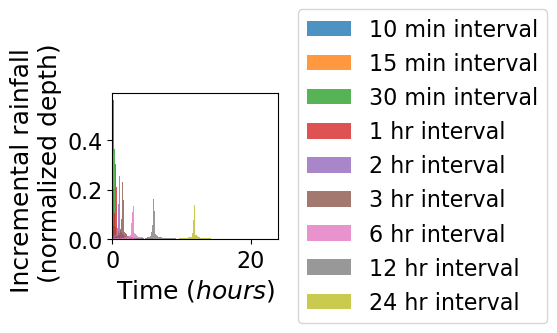

In [41]:
# Define intervals in hours
intervals = [0.1667, 0.25, 0.5, 1, 2, 3, 6, 12, 24]
# Store results
normalized_intervals = {}
# Compute and normalize rainfall for each interval
for interval in intervals:
    normalized_intervals[interval] = incremental_rainfall(
        max_n_hr_rainfall(rain_type=culvert.rain_type[0], interval_hours=interval)
    )
# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 3))  # Increase width to accommodate legend
# Plot each interval
for interval, depths in normalized_intervals.items():
    label = f"{int(interval * 60)} min interval" if interval < 1 else f"{interval} hr interval"
    ax.bar(np.linspace(0, interval, len(depths)), depths, width=interval/len(depths), label=label,alpha=0.8)
# Set labels and limits
ax.set_xlabel(f"Time ($hours$)")
ax.set_ylabel("Incremental rainfall \n (normalized depth)")
ax.set_xlim(0, 24)
# Move legend outside, right, and vertically centered
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
plt.tight_layout()
# Save the figure
#plt.savefig(r'D:\culvert repo\Results\Figures\normalized_temporal_incremental_rainfall_normalized_depths_typeII.png', 
#            dpi=300, bbox_inches='tight')
plt.show()

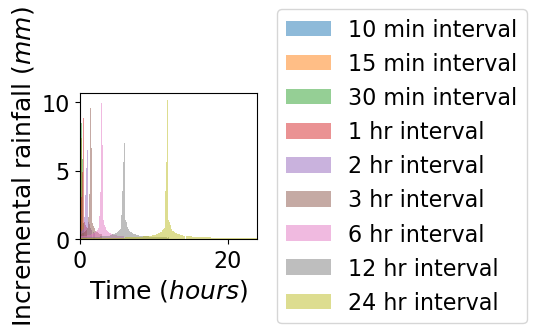

In [186]:
# Define intervals in hours
intervals = [0.1667, 0.25, 0.5, 1, 2, 3, 6, 12, 24]
depth = [
    culvert.rain_5_10m_a[4], culvert.rain_5_15m_a[4], culvert.rain_5_30m_a[4],
    culvert.rain_5_60m_a[4], culvert.rain_5_02h_a[4], culvert.rain_5_03h_a[4],
    culvert.rain_5_06h_a[4], culvert.rain_5_12h_a[4], culvert.rain_5_24h_a[4]
]
# Store results
normalized_intervals = {}
# Compute and normalize rainfall for each interval
for idx, interval in enumerate(intervals):
    rainfall = max_n_hr_rainfall(rain_type=culvert.rain_type[4], interval_hours=interval) * depth[idx] * 10
    normalized_intervals[interval] = incremental_rainfall(rainfall)
# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 3))  # Increase width to accommodate legend
# Plot each interval
for interval, depths in normalized_intervals.items():
    label = f"{int(interval * 60)} min interval" if interval < 1 else f"{interval} hr interval"
    ax.bar(np.linspace(0, interval, len(depths)), depths,width=interval/len(depths), label=label,alpha=0.5)
# Set labels and limits
ax.set_xlim(0, 24)
ax.set_xlabel(f"Time ($hours$)")
ax.set_ylabel(f"Incremental rainfall ($mm$)")
# Move legend outside, right, and vertically centered
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
plt.tight_layout()
# Save the figure
#plt.savefig(r'D:\culvert repo\Results\Figures\temporal_incremental_rainfall_depths_culv_1.png', 
#            dpi=300, bbox_inches='tight')
plt.show()

In [43]:
def calculate_excess_rainfall(rainfall_array, CN):
    # Curve number and initial abstraction calculations
    S = (25400 / CN) - 254
    I_default = 0.2 * S
    
    if len(rainfall_array)<6: 
        time_step=5 
    else: 
        time_step=6
    # Create a DataFrame with incremental depths (rainfall every 6 minutes)
    df = pd.DataFrame({
        'Time': np.arange(0, len(rainfall_array)*time_step, time_step),
        'Incremental Depths (mm)': rainfall_array
    })
    
    # Add the 'Cumulative Rainfall' column
    df['Cumulative Rainfall (mm)'] = df['Incremental Depths (mm)'].cumsum()
    
    # Calculate the 'Ia' (Initial Abstraction)
    df['Ia'] = df['Cumulative Rainfall (mm)'].apply(lambda P: min(P, I_default) if P < I_default else I_default)
    
    # Calculate the 'Fa' (Fraction of Runoff) only when runoff occurs
    df['Fa'] = np.where(df['Cumulative Rainfall (mm)'] > df['Ia'],
                        (S * (df['Cumulative Rainfall (mm)'] - df['Ia'])) / 
                        (df['Cumulative Rainfall (mm)'] + df['Ia'] + S), 0)
    
    # Calculate the 'Pe' (Excess Precipitation)
    df['Pe'] = np.maximum(df['Cumulative Rainfall (mm)'] - df['Ia'] - df['Fa'], 0)
    
    # Incremental Excess (difference in excess precipitation)
    df['Incremental Excess (mm)'] = df['Pe'].diff().fillna(df['Pe'])  # For the first value, just take 'Pe'
    
    return df

In [44]:
def construct_unit_hydrograph(tc, A, tr, time_step):
    """
    Constructs a unit hydrograph based on the given parameters.
    
    Parameters:
    tc (float): Time of concentration (in hours).
    A (float): Catchment area (in square kilometers).
    tr (float): Duration of excessive rainfall (in hours, default is 0.1 hour or 6 minutes).
    
    Returns:
    tuple: Time intervals (hours), discharge values (m³/s) at each interval, and the plot.
    """
    # Calculate parameters
    tp = 0.6 * tc  # Time to peak
    Tp = (tr / 2) + tp  # Time to peak of the unit hydrograph
    qp = 0.208 * A / Tp  # Peak discharge (m³/s)
    base = 2.67 * Tp  # Duration of the unit hydrograph
    
    # Calculate the slope of the second line of the triangle
    slope_second = (0 - qp) / (base - Tp)
    
    # Define the 6-minute intervals (converted to hours)
    intervals_in_hours = np.arange(0, base, time_step / 60)  # Time in hours for 6-minute intervals
    
    # Initialize a list to store discharge values at 6-minute intervals
    discharge_values = []

    # Calculate discharge for the unit hydrograph at each 6-minute interval
    for t in intervals_in_hours:
        if t <= Tp:
            discharge_values.append((qp / Tp) * t)  # Linear increase until Tp
        else:
            discharge_values.append(qp + slope_second * (t - Tp))  # Linear decrease after Tp
    
    # Plot the unit hydrograph
    time = np.linspace(0, base, 100)
    discharge = np.zeros_like(time)

    for i, t in enumerate(time):
        if t <= Tp:
            discharge[i] = (qp / Tp) * t  # Linear increase until Tp
        else:
            discharge[i] = qp + slope_second * (t - Tp)  # Linear decrease after Tp
    return intervals_in_hours, discharge_values

# Example usage with your culvert data
intervals, discharge_values = construct_unit_hydrograph(culvert.t_c[0], culvert.Area[0] / 10**6, 6 / 60, 6)

In [45]:
def calculate_total_discharge(df, unit_hydrograph):
    if len(df)<6:
        time_step=5
    else:
        time_step=6
    """
    Calculate the total discharge at each time step by applying the unit hydrograph
    to the incremental excess rainfall data.
    Parameters:
    df (pandas.DataFrame): DataFrame containing 'Time' and 'Incremental Excess (mm)' columns.
    unit_hydrograph (numpy.array): Array of unit hydrograph values for each time step.
    Returns:
    pandas.DataFrame: DataFrame with time steps, individual discharge values, and total discharge.
    """
    # Initialize a zero matrix for discharges, based on the number of time steps and unit hydrograph length
    discharge_matrix = np.zeros((len(df['Time']) + len(unit_hydrograph), len(df['Incremental Excess (mm)'])))
    # Loop through each Incremental Excess rainfall and calculate the discharge for each time step
    for idx, row in df.iterrows():
        # Multiply the Unit Hydrograph by the Incremental Excess value
        excess_rainfall = row['Incremental Excess (mm)']
        discharge_values = unit_hydrograph * excess_rainfall*(1/3.6)  # Multiply each Unit Hydrograph value by the Excess Rainfall
        # Find the start index where the rainfall begins (this corresponds to the current time step)
        start_idx = int(row['Time'] // time_step)  # Convert time step (in minutes) to the index (since it's a 6-minute interval)
        # Insert the discharge values starting from the corresponding time step
        discharge_matrix[start_idx:start_idx+len(unit_hydrograph), idx] = discharge_values
    # Create a DataFrame for the discharges
    discharge = pd.DataFrame(discharge_matrix, columns=[f'Discharge_{i+1}' for i in range(len(df['Incremental Excess (mm)']))])
    # Add the Time column to the DataFrame
    discharge['Time'] = np.concatenate([df['Time'], [df['Time'].iloc[-1] + time_step * (i+1) for i in range(len(unit_hydrograph))]])
    # Calculate the sum of discharges at each time step to get the total discharge
    discharge['Total Discharge'] = discharge.iloc[:, :-1].sum(axis=1)
    return discharge

# compute the discharges

In [210]:
def calculate_max_discharge_for_row(culvert, return_periods):
    intervals = [0.1667, 0.25, 0.5, 1, 2, 3, 6]
    # Initialize dictionary to store max discharge for each return period
    max_discharges = {}
    # Iterate over each return period
    max_dis = 0  
    for period in return_periods:
        # Loop through each interval
        for idx, interval in enumerate(intervals):
            # Set depth data (assuming the correct attributes are in `culvert`)
            # Use getattr to dynamically access the attribute based on the period
            depth = [
                getattr(culvert, f'rain_{period}_10m_a'),
                getattr(culvert, f'rain_{period}_15m_a'),
                getattr(culvert, f'rain_{period}_30m_a'),
                getattr(culvert, f'rain_{period}_60m_a'),
                getattr(culvert, f'rain_{period}_02h_a'),
                getattr(culvert, f'rain_{period}_03h_a'),
                getattr(culvert, f'rain_{period}_06h_a'),
                getattr(culvert, f'rain_{period}_12h_a'),
                getattr(culvert, f'rain_{period}_24h_a')
            ]
            # Compute and normalize rainfall for each interval
            rainfall = max_n_hr_rainfall(rain_type=culvert.rain_type, interval_hours=interval) * depth[idx] * 10
            normalized_intervals[interval]= incremental_rainfall(rainfall)
            # Calculate excess rainfall for each interval
            result_df = calculate_excess_rainfall(normalized_intervals[interval], CN=culvert.CN_wet)
            # Extract relevant data for discharge calculation
            df = result_df[['Time', 'Incremental Excess (mm)']]
            # Determine time step based on interval
            time_step = 5 if interval < 0.5 else 6
            # Generate unit hydrograph
            intervals_1, discharge_values = construct_unit_hydrograph(
                culvert.t_c_CN_wet, culvert.Area / 10**6, time_step / 60, time_step
            )
            unit_hydrograph = np.array(discharge_values)
            # Calculate total discharge for this interval
            discharge = calculate_total_discharge(df, unit_hydrograph)
            # Get the total discharge column
            total_discharge = discharge['Total Discharge']
            # Find the maximum discharge value for the current interval
            max_discharge_index = total_discharge.idxmax()
            max_discharge_row = discharge.iloc[max_discharge_index]
            # Check if the third-to-last element is non-zero and update max discharge if needed
            if max_discharge_row[-3] != 0:
                max_dis = max(max_dis, max_discharge_row[-1])        
        # Store the max discharge for this return period in the dictionary
        max_discharges[f'Q_{period}'] = max_dis*35.3147
    return max_discharges
# Define return periods and intervals
return_periods = [2, 5, 10, 25, 50, 100, 200, 500, 1000]

def apply_max_discharge(row):
    #print(f"Analyzing row with index: {row.name}")  # Print the index of the current row
    return calculate_max_discharge_for_row(row, return_periods)
# Apply the function to the rows of the "culvert" dataset with tqdm for row processing
max_discharge_df = pd.DataFrame([
    apply_max_discharge(row) for idx, row in tqdm(culvert.iterrows(), total=len(culvert), desc="Rows processing")
])
# Convert the dictionary results to separate columns and concatenate them to the original data
culvert_Q = pd.concat([culvert, max_discharge_df.apply(pd.Series)], axis=1)

Rows processing: 100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.36it/s]


In [211]:
culvert=culvert_Q
culvert

,BIN,Ini_lon,Ini_lat,lonsnap_10,latsnap_10,Area_10,Peri_10,LFP_len_10,LFP_S_10,Bas_S_10,cul_S10,lonsnap_20,latsnap_20,Area_20,Peri_20,LFP_len_20,LFP_S_20,Bas_S_20,cul_S20,lonsnap_40,latsnap_40,Area_40,Peri_40,LFP_len_40,LFP_S_40,Bas_S_40,cul_S40,lonsnap_80,latsnap_80,Area_80,Peri_80,LFP_len_80,LFP_S_80,Bas_S_80,cul_S80,geometry,Area,LFP_len,Bas_S,t_c,Closest_Area,CN,CN_dry,CN_wet,t_c_CN,t_c_CN_dry,t_c_CN_wet,CN_2030_A1B_Dry,CN_2030_A1B_Normal,CN_2030_A1B_Wet,CN_2040_A1B_Dry,CN_2040_A1B_Normal,CN_2040_A1B_Wet,CN_2050_A1B_Dry,CN_2050_A1B_Normal,CN_2050_A1B_Wet,CN_2060_A1B_Dry,CN_2060_A1B_Normal,CN_2060_A1B_Wet,CN_2070_A1B_Dry,CN_2070_A1B_Normal,CN_2070_A1B_Wet,CN_2080_A1B_Dry,CN_2080_A1B_Normal,CN_2080_A1B_Wet,CN_2090_A1B_Dry,CN_2090_A1B_Normal,CN_2090_A1B_Wet,CN_2100_A1B_Dry,CN_2100_A1B_Normal,CN_2100_A1B_Wet,CN_2030_A2_Dry,CN_2030_A2_Normal,CN_2030_A2_Wet,CN_2040_A2_Dry,CN_2040_A2_Normal,CN_2040_A2_Wet,CN_2050_A2_Dry,CN_2050_A2_Normal,CN_2050_A2_Wet,CN_2060_A2_Dry,CN_2060_A2_Normal,CN_2060_A2_Wet,CN_2070_A2_Dry,CN_2070_A2_Normal,CN_2070_A2_Wet,CN_2080_A2_Dry,CN_2080_A2_Normal,CN_2080_A2_Wet,CN_2090_A2_Dry,CN_2090_A2_Normal,CN_2090_A2_Wet,CN_2100_A2_Dry,CN_2100_A2_Normal,CN_2100_A2_Wet,CN_2030_B1_Dry,CN_2030_B1_Normal,CN_2030_B1_Wet,CN_2040_B1_Dry,CN_2040_B1_Normal,CN_2040_B1_Wet,CN_2050_B1_Dry,CN_2050_B1_Normal,CN_2050_B1_Wet,CN_2060_B1_Dry,CN_2060_B1_Normal,CN_2060_B1_Wet,CN_2070_B1_Dry,CN_2070_B1_Normal,CN_2070_B1_Wet,CN_2080_B1_Dry,CN_2080_B1_Normal,CN_2080_B1_Wet,CN_2090_B1_Dry,CN_2090_B1_Normal,CN_2090_B1_Wet,CN_2100_B1_Dry,CN_2100_B1_Normal,CN_2100_B1_Wet,CN_2030_B2_Dry,CN_2030_B2_Normal,CN_2030_B2_Wet,CN_2040_B2_Dry,CN_2040_B2_Normal,CN_2040_B2_Wet,CN_2050_B2_Dry,CN_2050_B2_Normal,CN_2050_B2_Wet,CN_2060_B2_Dry,CN_2060_B2_Normal,CN_2060_B2_Wet,CN_2070_B2_Dry,CN_2070_B2_Normal,CN_2070_B2_Wet,CN_2080_B2_Dry,CN_2080_B2_Normal,CN_2080_B2_Wet,CN_2090_B2_Dry,CN_2090_B2_Normal,CN_2090_B2_Wet,CN_2100_B2_Dry,CN_2100_B2_Normal,CN_2100_B2_Wet,t_CN_2030_A1B_Dry,t_CN_2030_A1B_Normal,t_CN_2030_A1B_Wet,t_CN_2040_A1B_Dry,t_CN_2040_A1B_Normal,t_CN_2040_A1B_Wet,t_CN_2050_A1B_Dry,t_CN_2050_A1B_Normal,t_CN_2050_A1B_Wet,t_CN_2060_A1B_Dry,t_CN_2060_A1B_Normal,t_CN_2060_A1B_Wet,t_CN_2070_A1B_Dry,t_CN_2070_A1B_Normal,t_CN_2070_A1B_Wet,t_CN_2080_A1B_Dry,t_CN_2080_A1B_Normal,t_CN_2080_A1B_Wet,t_CN_2090_A1B_Dry,t_CN_2090_A1B_Normal,t_CN_2090_A1B_Wet,t_CN_2100_A1B_Dry,t_CN_2100_A1B_Normal,t_CN_2100_A1B_Wet,t_CN_2030_A2_Dry,t_CN_2030_A2_Normal,t_CN_2030_A2_Wet,t_CN_2040_A2_Dry,t_CN_2040_A2_Normal,t_CN_2040_A2_Wet,t_CN_2050_A2_Dry,t_CN_2050_A2_Normal,t_CN_2050_A2_Wet,t_CN_2060_A2_Dry,t_CN_2060_A2_Normal,t_CN_2060_A2_Wet,t_CN_2070_A2_Dry,t_CN_2070_A2_Normal,t_CN_2070_A2_Wet,t_CN_2080_A2_Dry,t_CN_2080_A2_Normal,t_CN_2080_A2_Wet,t_CN_2090_A2_Dry,t_CN_2090_A2_Normal,t_CN_2090_A2_Wet,t_CN_2100_A2_Dry,t_CN_2100_A2_Normal,t_CN_2100_A2_Wet,t_CN_2030_B1_Dry,t_CN_2030_B1_Normal,t_CN_2030_B1_Wet,t_CN_2040_B1_Dry,t_CN_2040_B1_Normal,t_CN_2040_B1_Wet,t_CN_2050_B1_Dry,t_CN_2050_B1_Normal,t_CN_2050_B1_Wet,t_CN_2060_B1_Dry,t_CN_2060_B1_Normal,t_CN_2060_B1_Wet,t_CN_2070_B1_Dry,t_CN_2070_B1_Normal,t_CN_2070_B1_Wet,t_CN_2080_B1_Dry,t_CN_2080_B1_Normal,t_CN_2080_B1_Wet,t_CN_2090_B1_Dry,t_CN_2090_B1_Normal,t_CN_2090_B1_Wet,t_CN_2100_B1_Dry,t_CN_2100_B1_Normal,t_CN_2100_B1_Wet,t_CN_2030_B2_Dry,t_CN_2030_B2_Normal,t_CN_2030_B2_Wet,t_CN_2040_B2_Dry,t_CN_2040_B2_Normal,t_CN_2040_B2_Wet,t_CN_2050_B2_Dry,t_CN_2050_B2_Normal,t_CN_2050_B2_Wet,t_CN_2060_B2_Dry,t_CN_2060_B2_Normal,t_CN_2060_B2_Wet,t_CN_2070_B2_Dry,t_CN_2070_B2_Normal,t_CN_2070_B2_Wet,t_CN_2080_B2_Dry,t_CN_2080_B2_Normal,t_CN_2080_B2_Wet,t_CN_2090_B2_Dry,t_CN_2090_B2_Normal,t_CN_2090_B2_Wet,t_CN_2100_B2_Dry,t_CN_2100_B2_Normal,t_CN_2100_B2_Wet,S,Ia,S_dry,Ia_dry,S_wet,Ia_wet,S_2030_A1B_Dry,Ia_2030_A1B_Dry,S_2030_A1B_Normal,Ia_2030_A1B_Normal,S_2030_A1B_Wet,Ia_2030_A1B_Wet,S_2040_A1B_Dry,Ia_2040_A1B_Dry,S_2040_A1B_Normal,Ia_2040_A1B_Normal,S_2040_A1B_Wet,Ia_2040_A1B_Wet,S_2050_A1B_Dry,Ia_2050_A1B_Dry,S_2050_A1B_Norma

In [213]:
# upper bound
def calculate_max_discharge_for_row(culvert, return_periods):
    intervals = [0.1667, 0.25, 0.5, 1, 2, 3, 6, 12, 24]
    # Initialize a dictionary to store the max discharge for each return period
    max_discharges = {}
    max_dis = 0  # Reset max discharge for this period
    # Iterate over each return period
    for period in return_periods:
        update_next = False
        # Loop through each interval
        for idx, interval in enumerate(intervals):
            # Set depth data (assuming the correct attributes are in `culvert`)
            # Use getattr to dynamically access the attribute based on the period
            depth = [
                getattr(culvert, f'rain_{period}_10m_au'),
                getattr(culvert, f'rain_{period}_15m_au'),
                getattr(culvert, f'rain_{period}_30m_au'),
                getattr(culvert, f'rain_{period}_60m_au'),
                getattr(culvert, f'rain_{period}_02h_au'),
                getattr(culvert, f'rain_{period}_03h_au'),
                getattr(culvert, f'rain_{period}_06h_au'),
                getattr(culvert, f'rain_{period}_12h_au'),
                getattr(culvert, f'rain_{period}_24h_au')
            ]
            # Compute and normalize rainfall for each interval
            rainfall = max_n_hr_rainfall(rain_type=culvert.rain_type, interval_hours=interval) * depth[idx] * 10
            normalized_intervals[interval]= incremental_rainfall(rainfall)
            # Calculate excess rainfall for each interval
            result_df = calculate_excess_rainfall(normalized_intervals[interval], CN=np.maximum(culvert['CN_wet'], culvert['GEE_CN_wet']))
            # Extract relevant data for discharge calculation
            df = result_df[['Time', 'Incremental Excess (mm)']]
            # Determine time step based on interval
            time_step = 5 if interval < 0.5 else 6
            # Generate unit hydrograph
            intervals_1, discharge_values = construct_unit_hydrograph(
                np.minimum(culvert['t_c_CN_wet'], culvert['t_c_GEE_CN_wet']), culvert.Area / 10**6, time_step / 60, time_step
            )
            unit_hydrograph = np.array(discharge_values)
            # Calculate total discharge for this interval
            discharge = calculate_total_discharge(df, unit_hydrograph)
            # Get the total discharge column
            total_discharge = discharge['Total Discharge']
            # Find the maximum discharge value for the current interval
            max_discharge_index = total_discharge.idxmax()
            max_discharge_row = discharge.iloc[max_discharge_index]
            # Check if the third-to-last element is non-zero and update max discharge if needed
            if update_next:
                max_dis = max(max_dis, max_discharge_row[-1],culvert[f'Q_{period}']/35.3147)
                update_next = False  # Reset flag

            if max_discharge_row[-3] != 0:
                update_next = True  # Set flag to update in next iteration
                
        # Store the max discharge for this return period in the dictionary
        max_discharges[f'Q_UL_{period}'] = max_dis*35.3147
    return max_discharges
# Define return periods and intervals
return_periods = [2, 5, 10, 25, 50, 100, 200, 500, 1000]

def apply_max_discharge(row):
    #print(f"Analyzing row with index: {row.name}")  # Print the index of the current row
    return calculate_max_discharge_for_row(row, return_periods)
# Apply the function to the rows of the "culvert" dataset with tqdm for row processing
max_discharge_df = pd.DataFrame([
    apply_max_discharge(row) for idx, row in tqdm(culvert.iterrows(), total=len(culvert), desc="Rows processing")
])
# Convert the dictionary results to separate columns and concatenate them to the original data
culvert_Q = pd.concat([culvert, max_discharge_df.apply(pd.Series)], axis=1)

Rows processing: 100%|███████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


In [214]:
culvert=culvert_Q
culvert

,BIN,Ini_lon,Ini_lat,lonsnap_10,latsnap_10,Area_10,Peri_10,LFP_len_10,LFP_S_10,Bas_S_10,cul_S10,lonsnap_20,latsnap_20,Area_20,Peri_20,LFP_len_20,LFP_S_20,Bas_S_20,cul_S20,lonsnap_40,latsnap_40,Area_40,Peri_40,LFP_len_40,LFP_S_40,Bas_S_40,cul_S40,lonsnap_80,latsnap_80,Area_80,Peri_80,LFP_len_80,LFP_S_80,Bas_S_80,cul_S80,geometry,Area,LFP_len,Bas_S,t_c,Closest_Area,CN,CN_dry,CN_wet,t_c_CN,t_c_CN_dry,t_c_CN_wet,CN_2030_A1B_Dry,CN_2030_A1B_Normal,CN_2030_A1B_Wet,CN_2040_A1B_Dry,CN_2040_A1B_Normal,CN_2040_A1B_Wet,CN_2050_A1B_Dry,CN_2050_A1B_Normal,CN_2050_A1B_Wet,CN_2060_A1B_Dry,CN_2060_A1B_Normal,CN_2060_A1B_Wet,CN_2070_A1B_Dry,CN_2070_A1B_Normal,CN_2070_A1B_Wet,CN_2080_A1B_Dry,CN_2080_A1B_Normal,CN_2080_A1B_Wet,CN_2090_A1B_Dry,CN_2090_A1B_Normal,CN_2090_A1B_Wet,CN_2100_A1B_Dry,CN_2100_A1B_Normal,CN_2100_A1B_Wet,CN_2030_A2_Dry,CN_2030_A2_Normal,CN_2030_A2_Wet,CN_2040_A2_Dry,CN_2040_A2_Normal,CN_2040_A2_Wet,CN_2050_A2_Dry,CN_2050_A2_Normal,CN_2050_A2_Wet,CN_2060_A2_Dry,CN_2060_A2_Normal,CN_2060_A2_Wet,CN_2070_A2_Dry,CN_2070_A2_Normal,CN_2070_A2_Wet,CN_2080_A2_Dry,CN_2080_A2_Normal,CN_2080_A2_Wet,CN_2090_A2_Dry,CN_2090_A2_Normal,CN_2090_A2_Wet,CN_2100_A2_Dry,CN_2100_A2_Normal,CN_2100_A2_Wet,CN_2030_B1_Dry,CN_2030_B1_Normal,CN_2030_B1_Wet,CN_2040_B1_Dry,CN_2040_B1_Normal,CN_2040_B1_Wet,CN_2050_B1_Dry,CN_2050_B1_Normal,CN_2050_B1_Wet,CN_2060_B1_Dry,CN_2060_B1_Normal,CN_2060_B1_Wet,CN_2070_B1_Dry,CN_2070_B1_Normal,CN_2070_B1_Wet,CN_2080_B1_Dry,CN_2080_B1_Normal,CN_2080_B1_Wet,CN_2090_B1_Dry,CN_2090_B1_Normal,CN_2090_B1_Wet,CN_2100_B1_Dry,CN_2100_B1_Normal,CN_2100_B1_Wet,CN_2030_B2_Dry,CN_2030_B2_Normal,CN_2030_B2_Wet,CN_2040_B2_Dry,CN_2040_B2_Normal,CN_2040_B2_Wet,CN_2050_B2_Dry,CN_2050_B2_Normal,CN_2050_B2_Wet,CN_2060_B2_Dry,CN_2060_B2_Normal,CN_2060_B2_Wet,CN_2070_B2_Dry,CN_2070_B2_Normal,CN_2070_B2_Wet,CN_2080_B2_Dry,CN_2080_B2_Normal,CN_2080_B2_Wet,CN_2090_B2_Dry,CN_2090_B2_Normal,CN_2090_B2_Wet,CN_2100_B2_Dry,CN_2100_B2_Normal,CN_2100_B2_Wet,t_CN_2030_A1B_Dry,t_CN_2030_A1B_Normal,t_CN_2030_A1B_Wet,t_CN_2040_A1B_Dry,t_CN_2040_A1B_Normal,t_CN_2040_A1B_Wet,t_CN_2050_A1B_Dry,t_CN_2050_A1B_Normal,t_CN_2050_A1B_Wet,t_CN_2060_A1B_Dry,t_CN_2060_A1B_Normal,t_CN_2060_A1B_Wet,t_CN_2070_A1B_Dry,t_CN_2070_A1B_Normal,t_CN_2070_A1B_Wet,t_CN_2080_A1B_Dry,t_CN_2080_A1B_Normal,t_CN_2080_A1B_Wet,t_CN_2090_A1B_Dry,t_CN_2090_A1B_Normal,t_CN_2090_A1B_Wet,t_CN_2100_A1B_Dry,t_CN_2100_A1B_Normal,t_CN_2100_A1B_Wet,t_CN_2030_A2_Dry,t_CN_2030_A2_Normal,t_CN_2030_A2_Wet,t_CN_2040_A2_Dry,t_CN_2040_A2_Normal,t_CN_2040_A2_Wet,t_CN_2050_A2_Dry,t_CN_2050_A2_Normal,t_CN_2050_A2_Wet,t_CN_2060_A2_Dry,t_CN_2060_A2_Normal,t_CN_2060_A2_Wet,t_CN_2070_A2_Dry,t_CN_2070_A2_Normal,t_CN_2070_A2_Wet,t_CN_2080_A2_Dry,t_CN_2080_A2_Normal,t_CN_2080_A2_Wet,t_CN_2090_A2_Dry,t_CN_2090_A2_Normal,t_CN_2090_A2_Wet,t_CN_2100_A2_Dry,t_CN_2100_A2_Normal,t_CN_2100_A2_Wet,t_CN_2030_B1_Dry,t_CN_2030_B1_Normal,t_CN_2030_B1_Wet,t_CN_2040_B1_Dry,t_CN_2040_B1_Normal,t_CN_2040_B1_Wet,t_CN_2050_B1_Dry,t_CN_2050_B1_Normal,t_CN_2050_B1_Wet,t_CN_2060_B1_Dry,t_CN_2060_B1_Normal,t_CN_2060_B1_Wet,t_CN_2070_B1_Dry,t_CN_2070_B1_Normal,t_CN_2070_B1_Wet,t_CN_2080_B1_Dry,t_CN_2080_B1_Normal,t_CN_2080_B1_Wet,t_CN_2090_B1_Dry,t_CN_2090_B1_Normal,t_CN_2090_B1_Wet,t_CN_2100_B1_Dry,t_CN_2100_B1_Normal,t_CN_2100_B1_Wet,t_CN_2030_B2_Dry,t_CN_2030_B2_Normal,t_CN_2030_B2_Wet,t_CN_2040_B2_Dry,t_CN_2040_B2_Normal,t_CN_2040_B2_Wet,t_CN_2050_B2_Dry,t_CN_2050_B2_Normal,t_CN_2050_B2_Wet,t_CN_2060_B2_Dry,t_CN_2060_B2_Normal,t_CN_2060_B2_Wet,t_CN_2070_B2_Dry,t_CN_2070_B2_Normal,t_CN_2070_B2_Wet,t_CN_2080_B2_Dry,t_CN_2080_B2_Normal,t_CN_2080_B2_Wet,t_CN_2090_B2_Dry,t_CN_2090_B2_Normal,t_CN_2090_B2_Wet,t_CN_2100_B2_Dry,t_CN_2100_B2_Normal,t_CN_2100_B2_Wet,S,Ia,S_dry,Ia_dry,S_wet,Ia_wet,S_2030_A1B_Dry,Ia_2030_A1B_Dry,S_2030_A1B_Normal,Ia_2030_A1B_Normal,S_2030_A1B_Wet,Ia_2030_A1B_Wet,S_2040_A1B_Dry,Ia_2040_A1B_Dry,S_2040_A1B_Normal,Ia_2040_A1B_Normal,S_2040_A1B_Wet,Ia_2040_A1B_Wet,S_2050_A1B_Dry,Ia_2050_A1B_Dry,S_2050_A1B_Norma

In [215]:
def calculate_max_discharge_for_row(culvert, return_periods):
    intervals = [0.1667, 0.25, 0.5, 1, 2, 3, 6, 12, 24]
    # Initialize a dictionary to store the max discharge for each return period
    max_discharges = {}
    max_dis = 0  # Reset max discharge for this period

    # Iterate over each return period
    for period in return_periods:
        # Loop through each interval
        for idx, interval in enumerate(intervals):
            # Set depth data (assuming the correct attributes are in `culvert`)
            # Use getattr to dynamically access the attribute based on the period
            depth = [
                getattr(culvert, f'rain_{period}_10m_al'),
                getattr(culvert, f'rain_{period}_15m_al'),
                getattr(culvert, f'rain_{period}_30m_al'),
                getattr(culvert, f'rain_{period}_60m_al'),
                getattr(culvert, f'rain_{period}_02h_al'),
                getattr(culvert, f'rain_{period}_03h_al'),
                getattr(culvert, f'rain_{period}_06h_al'),
                getattr(culvert, f'rain_{period}_12h_al'),
                getattr(culvert, f'rain_{period}_24h_al')
            ]
            # Compute and normalize rainfall for each interval
            rainfall = max_n_hr_rainfall(rain_type=culvert.rain_type, interval_hours=interval) * depth[idx] * 10
            normalized_intervals[interval]= incremental_rainfall(rainfall)
            # Calculate excess rainfall for each interval
            result_df = calculate_excess_rainfall(normalized_intervals[interval], CN=np.minimum(culvert['CN_wet'], culvert['GEE_CN_wet']))
            # Extract relevant data for discharge calculation
            df = result_df[['Time', 'Incremental Excess (mm)']]
            # Determine time step based on interval
            time_step = 5 if interval < 0.5 else 6
            # Generate unit hydrograph
            intervals_1, discharge_values = construct_unit_hydrograph(
                np.maximum(culvert['t_c_CN_wet'], culvert['t_c_GEE_CN_wet']), culvert.Area / 10**6, time_step / 60, time_step
            )
            unit_hydrograph = np.array(discharge_values)
            # Calculate total discharge for this interval
            discharge = calculate_total_discharge(df, unit_hydrograph)
            # Get the total discharge column
            total_discharge = discharge['Total Discharge']
            # Find the maximum discharge value for the current interval
            max_discharge_index = total_discharge.idxmax()
            max_discharge_row = discharge.iloc[max_discharge_index]
            # Check if the third-to-last element is non-zero and update max discharge if needed
            if max_discharge_row[-3] != 0:
                max_dis = max(max_dis, max_discharge_row[-1])
        # Store the max discharge for this return period in the dictionary
        max_dis= min (max_dis,culvert[f'Q_{period}']/35.3147)
        max_discharges[f'Q_LL_{period}'] = max_dis*35.3147
    return max_discharges
# Define return periods and intervals
return_periods = [2, 5, 10, 25, 50, 100, 200, 500, 1000]

def apply_max_discharge(row):
    #print(f"Analyzing row with index: {row.name}")  # Print the index of the current row
    return calculate_max_discharge_for_row(row, return_periods)
# Apply the function to the rows of the "culvert" dataset with tqdm for row processing
max_discharge_df = pd.DataFrame([
    apply_max_discharge(row) for idx, row in tqdm(culvert.iterrows(), total=len(culvert), desc="Rows processing")
])
# Convert the dictionary results to separate columns and concatenate them to the original data
culvert_Q = pd.concat([culvert, max_discharge_df.apply(pd.Series)], axis=1)

Rows processing: 100%|███████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


In [216]:
culvert=culvert_Q

In [217]:
culvert[['BIN','Q_LL_2','Q_2','Q_UL_2','Q_LL_5','Q_5','Q_UL_5']]

,BIN,Q_LL_2,Q_2,Q_UL_2,Q_LL_5,Q_5,Q_UL_5
0,1362342,100.802175,121.597638,560.916103,137.443872,323.969464,969.670124
1,1422389,21.087306,45.613894,135.339127,31.610474,90.690298,263.435487
2,4253294,0.000000,9.855527,67.417128,16.013411,43.286844,132.867554
3,4253296,12.211864,47.804906,123.000855,28.775537,105.253919,183.196010
4,4253295,0.908620,1.152368,9.244316,1.152368,1.152368,19.853135


In [220]:
path= r"D:\culvert repo\Results\Validation\discharge\val_discharge_streanstats_NRCS.csv"
dis=pd.read_csv(path)
#dis = dis.drop(index=4) 
dis[]
dis.head()

,site_no,lower_2_year,2_year,upper_2_year,lower_5_year,5_year,upper_5_year,Str_stat_2_year,Str_stat_5_year
0,1362342,83.000000,115.00,158.777461,157.956062,231.80,421.318152,170.00,308.0
1,1422389,14.933120,19.50,34.066881,26.159230,34.80,45.000000,76.00,121.0
2,4253294,6.742180,9.00,20.211926,11.304381,21.70,65.829992,8.98,13.2
3,4253295,2.635332,3.59,5.829233,5.006095,7.57,9.831646,6.93,10.1
4,4253296,51.190455,74.65,105.086884,81.808789,110.40,200.659983,44.60,65.0


In [223]:
merged_df = pd.merge(culvert[['BIN','Q_LL_2','Q_2','Q_UL_2','Q_LL_5','Q_5','Q_UL_5']], dis, left_on='BIN', right_on='site_no', how='inner')
merged_df


,BIN,Q_LL_2,Q_2,Q_UL_2,Q_LL_5,Q_5,Q_UL_5,site_no,lower_2_year,2_year,upper_2_year,lower_5_year,5_year,upper_5_year,Str_stat_2_year,Str_stat_5_year
0,1362342,100.802175,121.597638,560.916103,137.443872,323.969464,969.670124,1362342,83.000000,115.00,158.777461,157.956062,231.80,421.318152,170.00,308.0
1,1422389,21.087306,45.613894,135.339127,31.610474,90.690298,263.435487,1422389,14.933120,19.50,34.066881,26.159230,34.80,45.000000,76.00,121.0
2,4253294,0.000000,9.855527,67.417128,16.013411,43.286844,132.867554,4253294,6.742180,9.00,20.211926,11.304381,21.70,65.829992,8.98,13.2
3,4253296,12.211864,47.804906,123.000855,28.775537,105.253919,183.196010,4253296,51.190455,74.65,105.086884,81.808789,110.40,200.659983,44.60,65.0
4,4253295,0.908620,1.152368,9.244316,1.152368,1.152368,19.853135,4253295,2.635332,3.59,5.829233,5.006095,7.57,9.831646,6.93,10.1


In [224]:
output_path = r"D:\culvert repo\Results\Validation\discharge\val_discharge_streanstats_NRCS_LL_UP.csv"
merged_df.to_csv(output_path, index=False)

In [3]:
# Date and time
now = datetime.datetime.now()
print(f"Date and time: {now}")

Date and time: 2025-05-12 09:15:01.602626


In [4]:
%load_ext watermark
# Print the Python version and some dependencies
%watermark -v -m -p numpy,pandas,geopandas,sklearn,matplotlib,seaborn,os,rasterio,tqdm,scipy

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.20.0

numpy     : 2.0.2
pandas    : 2.2.2
geopandas : 1.0.1
sklearn   : 1.5.1
matplotlib: 3.8.4
seaborn   : 0.13.2
os        : unknown
rasterio  : 1.4.3
tqdm      : 4.66.5
scipy     : 1.13.1

Compiler    : MSC v.1940 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 183 Stepping 1, GenuineIntel
CPU cores   : 24
Architecture: 64bit

